### **Соотношение датасетов `ga_sessions.csv` и `ga_hits.csv**`

| Характеристика       | `ga_sessions.csv` (Сессии)               | `ga_hits.csv` (События)                 |
|----------------------|------------------------------------------|------------------------------------------|
| **Уровень данных**   | Сессионный уровень                      | Событийный уровень                      |
| **Описание**         | Одна строка = один визит на сайт        | Одна строка = одно действие в визите    |
| **Ключевые поля**    | `session_id`, `client_id`               | `session_id`, `hit_number`              |
| **Примеры данных**   | UTM-метки, устройство, геолокация       | Просмотры страниц, клики, отправка форм |
| **Роль в анализе**   | Контекст визита (источник, устройство)  | Поведение пользователя на сайте         |
| **Связь**           | Связывается по `session_id`             | Присоединяется к сессиям                |

In [1]:
#!pip install -q gdown missingno plotly
import pandas as pd
from tkinter import Tk, filedialog
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
import gdown

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎯 Библиотеки загружены успешно!")

# Настройка графиков
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

🎯 Библиотеки загружены успешно!


# 1. Датасет: ga_hits.csv

Описание: Данные о событиях пользователей

Тип: CSV

Размер: 3,97 ГБ


### **Анализ структуры DataFrame**

| # | Колонка         | Non-Null Count | % Заполненности | Dtype   | Описание                          | Проблемы              | Рекомендации                     |
|---|-----------------|----------------|------------------|---------|-----------------------------------|-----------------------|----------------------------------|
| 0 | `session_id`    | 15,726,470     | 100%             | object  | ID визита              | -                     | -      |
| 1 | `hit_date`      | 15,726,470     | 100%             | object  | Дата события                      | Неоптимальный тип     | `pd.to_datetime()`               |
| 2 | `hit_time`      | 6,566,148      | 41.7%            | float64 | Время события                     | 58.3% пропусков       | Заполнить медианой               |
| 3 | `hit_number`    | 15,726,470     | 100%             | int64   | Порядковый номер события в рамках сессии          | -                     | -                                |
| 4 | `hit_type`      | 15,726,470     | 100%             | object  | Тип события               | Бесполезное хранение данных (одна и таже стркоа "event", нулевая информативность)                     | Удалить столбец    |
| 5 | `hit_referer`   | 9,451,666      | 60%              | object  | Источник события                 | хэши, 40% пропусков         | удалить или запросить корректные данные, или вручную расшифровать     |
| 6 | `hit_page_path` | 15,726,470     | 100%             | object  | URL страницы события                     | -                     | Выделить тип действия, рассмотреть оптимизацию столбца hit_page_path для предсказательной модели (цель Преобразовать сырые URL в признаки (features), которые помогут модели предсказывать целевые действия (оставление заявки, заказ звонка и т.д.).)          |
| 7 | `event_category`| 15,726,470     | 100%             | object  | Категория события                 | Неоптимальный тип данных, разрозненные категории, опечатки                     | Конвертировать в `category`      |
| 8 | `event_action`  | 15,726,470     | 100%             | object  | Действие пользователя             | -                     | Фильтровать ключевые действия, рассматривать, как целевое действие   |
| 9 | `event_label`   | 11,966,286     | 76%              | object  | Тег действия              | хеши, 24% пропусков         | Заполнить "unknown"              |
|10 | `event_value`   | 0              | 0%               | float64 | Числовое значение события         | Полностью пустая      | Удалить колонку                  |

### **Ключевая статистика**
- **Всего строк**: 15,726,470
- **Объем памяти**: 1.3+ GB
- **Основные проблемы**:
  - 58.3% пропусков в `hit_time`
  - Пустая колонка `event_value`
  - хеши, 9,160,322 пропущенных значений в `hit_referer`
  - хеши, пропущенные значения в  в`event_label`

In [17]:
import pandas as pd

file_path = r'ga_hits.csv'

try:
    # Загрузка данных
    df_hits = pd.read_csv("ga_hits.csv")
    df_hits
    
    # Проверка данных (первые 5 строк)
    print("Данные успешно загружены! Первые 5 строк:")
    print(df_hits.head())
    
    # Дополнительная информация о данных (столбцы, типы данных)
    print("\nИнформация о данных:")
    print(df_hits.info())
    
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути {file_path}")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Данные успешно загружены! Первые 5 строк:
                                  session_id    hit_date  hit_time  \
0  5639623078712724064.1640254056.1640254056  2021-12-23  597864.0   
1  7750352294969115059.1640271109.1640271109  2021-12-23  597331.0   
2   885342191847998240.1640235807.1640235807  2021-12-23  796252.0   
3   142526202120934167.1640211014.1640211014  2021-12-23  934292.0   
4  3450086108837475701.1640265078.1640265078  2021-12-23  768741.0   

   hit_number hit_type hit_referer  \
0          30    event         NaN   
1          41    event         NaN   
2          49    event         NaN   
3          46    event         NaN   
4          79    event         NaN   

                                       hit_page_path event_category  \
0  sberauto.com/cars?utm_source_initial=google&ut...           quiz   
1  sberauto.com/cars/fiat?city=1&city=18&rental_c...           quiz   
2  sberauto.com/cars/all/volkswagen/polo/e994838f...           quiz   
3  sberauto.com/cars?utm

In [3]:
df_hits.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   session_id      15726470 non-null  object 
 1   hit_date        15726470 non-null  object 
 2   hit_time        6566148 non-null   float64
 3   hit_number      15726470 non-null  int64  
 4   hit_type        15726470 non-null  object 
 5   hit_referer     9451666 non-null   object 
 6   hit_page_path   15726470 non-null  object 
 7   event_category  15726470 non-null  object 
 8   event_action    15726470 non-null  object 
 9   event_label     11966286 non-null  object 
 10  event_value     0 non-null         float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


Таблица типизации для DataFrame: df_hits 

| Колонка           | Тип признака      | Подтип          |  
|-------------------|-------------------|-----------------|  
| session_id        | категориальный    | номинальный    |  
| hit_date          | дата              |                |  
| hit_time          | числовой          | непрерывный    | 
| hit_number        | категориальный    | порядковый     |  
| hit_type          | категориальный    | номинальный    |  
| hit_referer       | категориальный    | номинальный    |
| hit_page_path     | категориальный    | номинальный    |
| event_category    | категориальный    | номинальный    |  
| event_action      | категориальный    | номинальный    |  
| event_label       | категориальный    | номинальный    |  
| event_value       | числовой          | непрерывный    |


In [18]:
print(df_hits['hit_type'].unique())

['event']


'hit_type' - Бесполезное хранение данных (одна и таже стркоа "event", нулевая информативность)

In [5]:
print(df_hits['hit_referer'].unique())

[nan 'VloVXNWduHeTjUoDkjkO' 'trXmoxcphNjuYcShOXwL' ...
 'SyKCPVqPvVwsypNSfuig' 'KpKtMqJlrvgANamYaRSI' 'tvGabHlPFDvTmIFiCKTL']


'hit_referer'- 40% пропусков, удалить

In [6]:
print(df_hits['event_category'].unique())

['quiz' 'card_web' 'sub_page_view' 'search_form' 'auth' 'chat' 'offers'
 'ad_banner' 'navigation' 'profile_menu' 'sub_button_click' 'listing_ads'
 'cars' 'sub_submit' 'main_banners' 'header' 'sap_search_form'
 'active_invitation' 'sap_search__form' 'footer' 'scrolling_main_page'
 'my_idea' 'phone' 'main_services' 'greenday_sub_button_click'
 'greenday_listing_ads' 'greenday_gtm.triggergroup' 'credit_buttons'
 'add_ad_vin' 'add_ad' 'category_tile' 'greenday_sub_submit' 'pos_landing'
 'greenday_sub_page_view' 'add_ad_publish_success' 'add_ad_city'
 'add_ad_description' 'add_ad_additional_information' 'add_ad_photo'
 'wallet' 'add_ad_preview' 'add_ad_form' 'main_advantages'
 'greenday_card_web' 'add_ad_documents' 'credit_landing_pos'
 'add_ad_price' 'add_ad_options' 'jivosite' 'tesla' 'app_banner'
 'titul_form']


Анализ пропусков данных с помощью missingno
Размер данных: (15726470, 11)


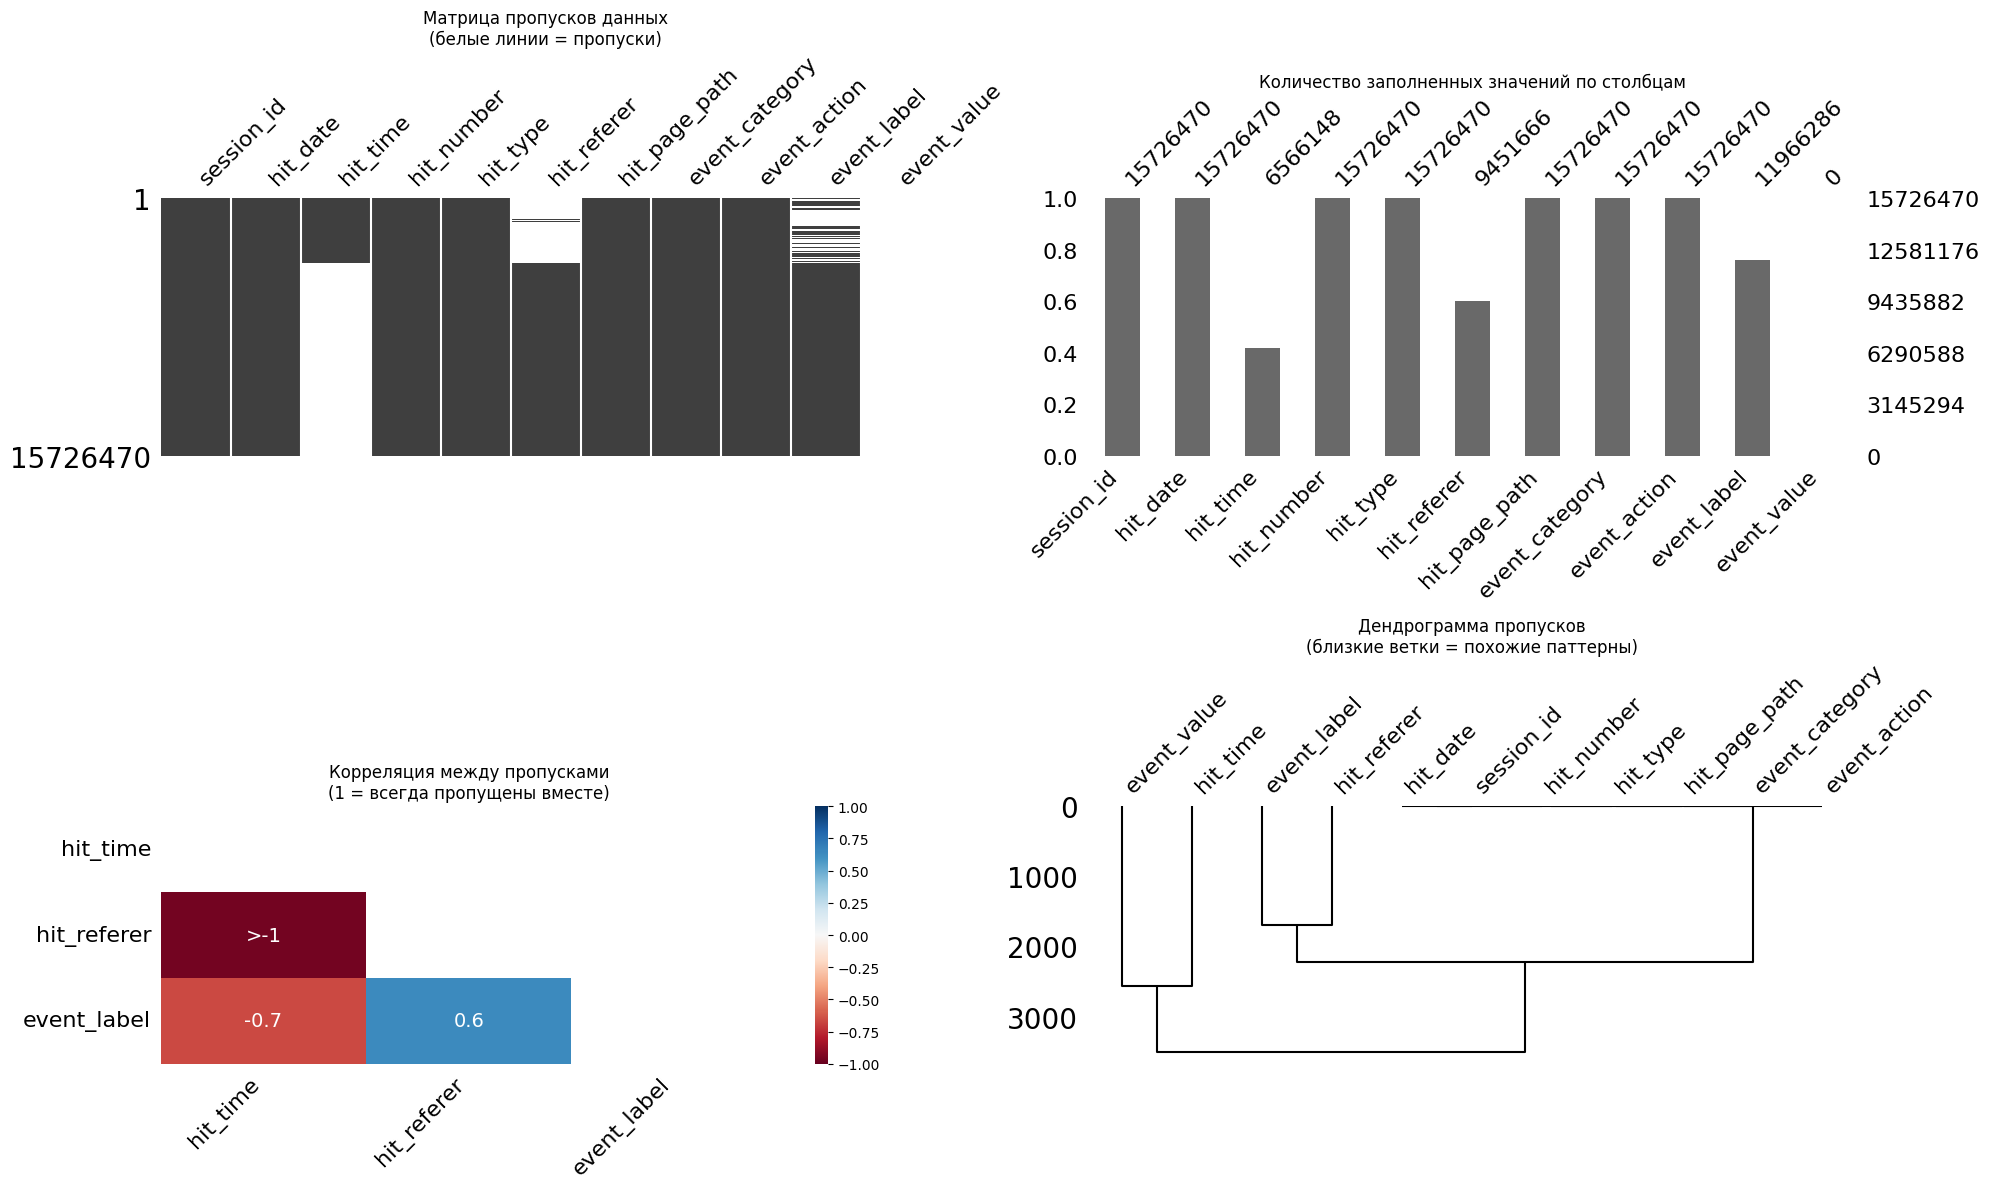


Статистика пропусков:
  hit_time: 9,160,322 (58.25%)
  hit_referer: 6,274,804 (39.90%)
  event_label: 3,760,184 (23.91%)
  event_value: 15,726,470 (100.00%)


In [7]:
# Анализ пропусков с помощью missingno
print("Анализ пропусков данных с помощью missingno")
print(f"Размер данных: {df_hits.shape}")

# Создаем фигуру с несколькими субплотами
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Matrix plot - основная визуализация пропусков
plt.subplot(2, 2, 1)
missingno.matrix(df_hits, ax=plt.gca(), sparkline=False)
plt.title('Матрица пропусков данных\n(белые линии = пропуски)', fontsize=12)

# 2. Bar plot - количество заполненных значений по столбцам
plt.subplot(2, 2, 2)
missingno.bar(df_hits, ax=plt.gca())
plt.title('Количество заполненных значений по столбцам', fontsize=12)

# 3. Heatmap - корреляция между пропусками
plt.subplot(2, 2, 3)
missingno.heatmap(df_hits, ax=plt.gca())
plt.title('Корреляция между пропусками\n(1 = всегда пропущены вместе)', fontsize=12)

# 4. Dendrogram - кластеризация столбцов по паттернам пропусков
plt.subplot(2, 2, 4)
missingno.dendrogram(df_hits, ax=plt.gca())
plt.title('Дендрограмма пропусков\n(близкие ветки = похожие паттерны)', fontsize=12)

plt.tight_layout()
plt.show()

# Статистика пропусков
missing_stats = df_hits.isnull().sum()
missing_percent = (missing_stats / len(df_hits)) * 100

print("\nСтатистика пропусков:")
for col in missing_stats[missing_stats > 0].index:
    count = missing_stats[col]
    percent = missing_percent[col]
    print(f"  {col}: {count:,} ({percent:.2f}%)")

if missing_stats.sum() == 0:
    print("  ✅ Пропуски отсутствуют!")

Исходя из анализа графиков мы видим, что по таким данным как hit_time, hit_referer, event_label, event_value присутствует значительный (от 23 до 100%) пропуск данных. 

In [ ]:
pd.crosstab(df_sessions['utm_keyword'].isna(), df_sessions['device_os'].isna())

📄 Визуализация популярных страниц:


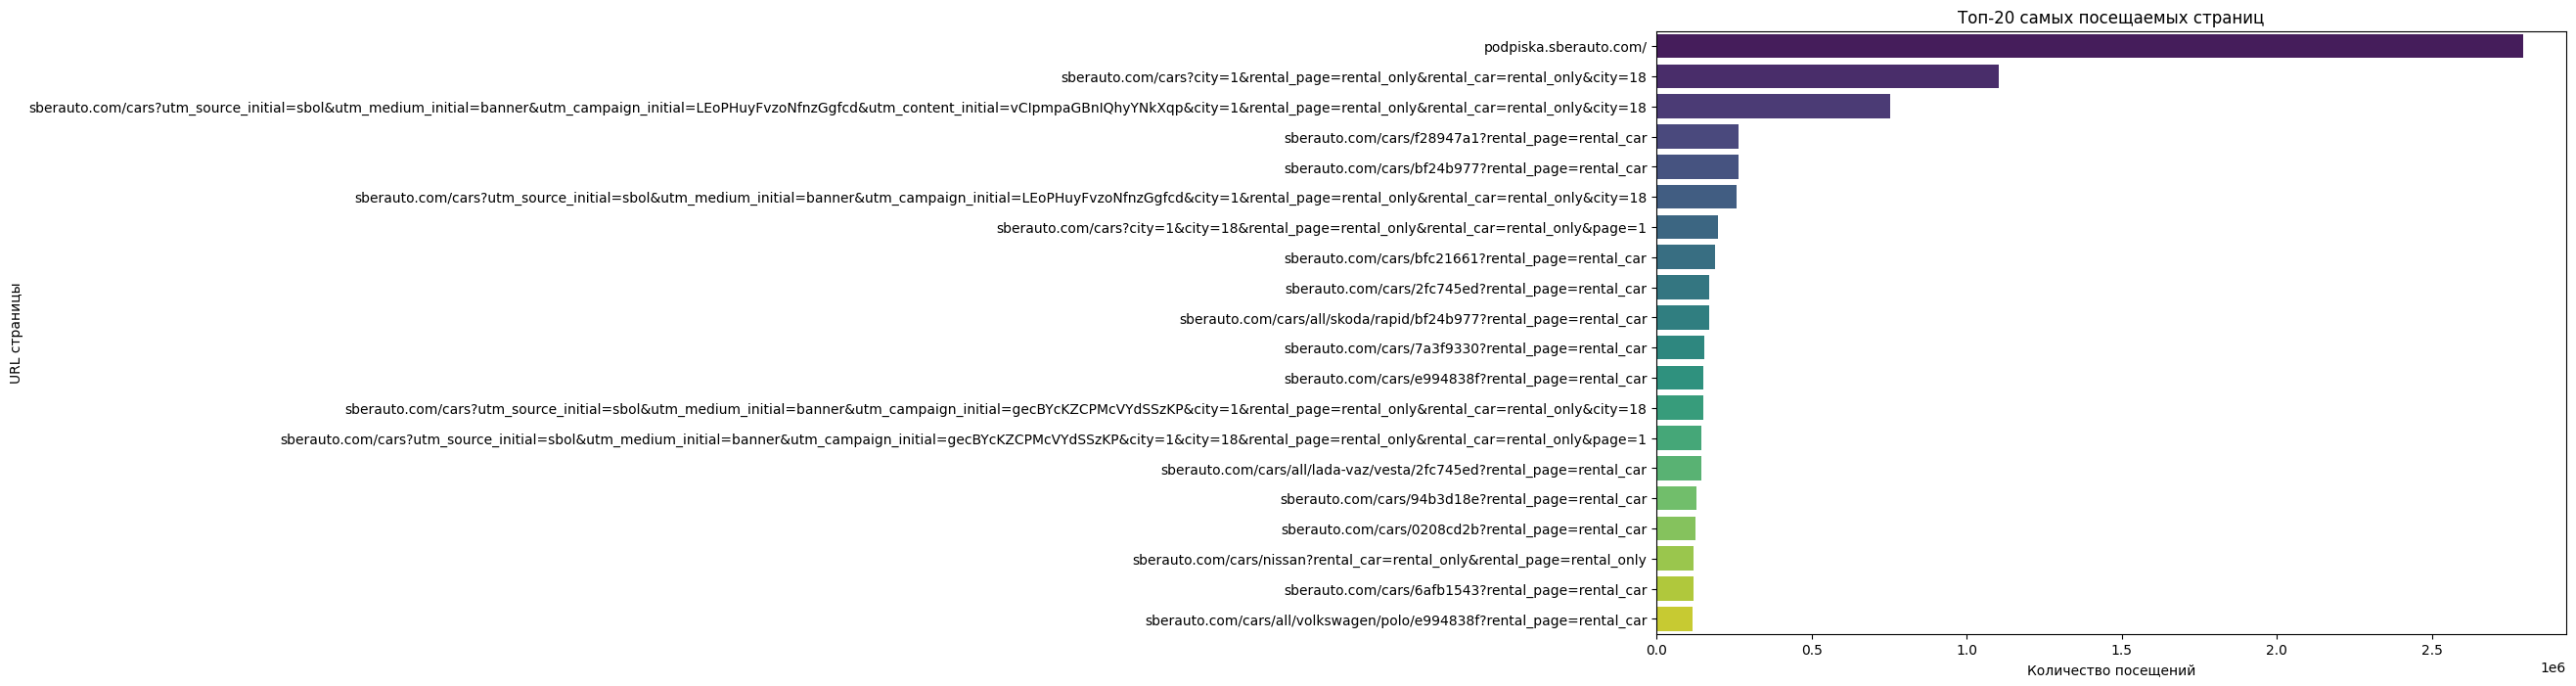

In [8]:
# Визуализация популярных страниц
print("📄 Визуализация популярных страниц:")
top_pages = df_hits['hit_page_path'].value_counts().head(20)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_pages.index, x=top_pages.values, palette="viridis")
plt.title("Топ-20 самых посещаемых страниц")
plt.xlabel("Количество посещений")
plt.ylabel("URL страницы")
plt.tight_layout()
plt.show()

Из приведенного выше графика видим, что 3 наиболее посещаемые страницы сайта - гланвая страница подписки, страница с фильтром по аренде автомобилей по конкретному городу, а также страница-лендинг, на которую ведет баннер с сайта сберонлайн.

📊 Анализ событий в сессиях:


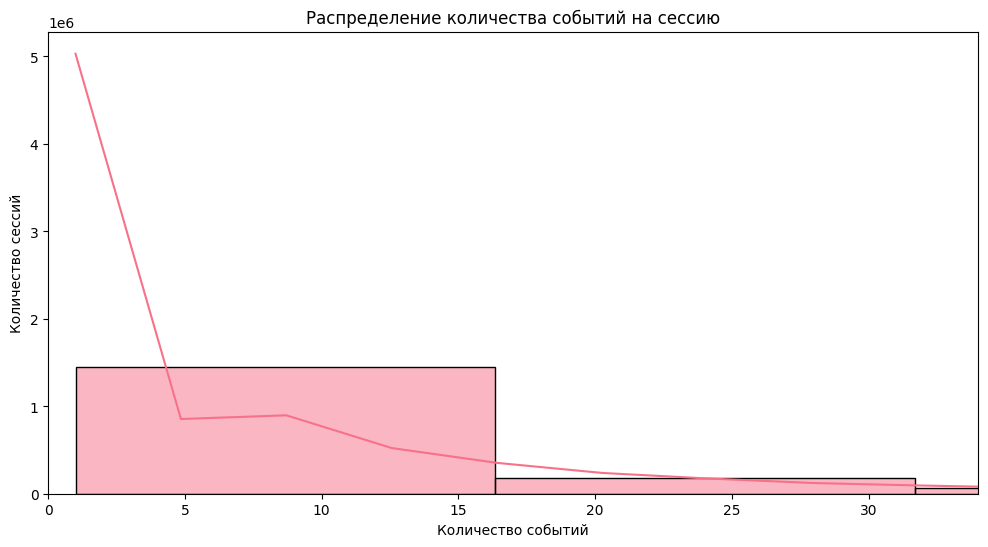

In [9]:
# Анализ событий в сессиях
print("📊 Анализ событий в сессиях:")
events_per_session = df_hits.groupby('session_id').size()
plt.figure(figsize=(12, 6))
sns.histplot(events_per_session, bins=50, kde=True)
plt.title("Распределение количества событий на сессию")
plt.xlabel("Количество событий")
plt.ylabel("Количество сессий")
plt.xlim(0, events_per_session.quantile(0.95))  # Исключаем выбросы
plt.show()

Низкое количество событий может коррелировать с высоким или низким CR в зависимости от сценария:

Если пользователи быстро совершают целевые действия (например, сразу нажимают «Оставить заявку»), это положительный сигнал.

Если они уходят после 1–2 просмотренных страниц – возможна проблема с контентом или UX.

Длинные сессии требуют дополнительного анализа путей навигации (например, через тепловые карты), чтобы определить, какие страницы вызывают затруднения.

Связь с другими данными:

Пользователи на мобильных устройствах (60% трафика) могут совершать меньше событий из-за неудобного интерфейса.

Сессии с платного трафика (70% визитов) могут иметь более короткий путь к целевому действию, чем органические.

Гипотеза: Короткие сессии преобладают из-за эффективности рекламных кампаний (пользователи сразу видят нужный CTA) или, наоборот, из-за высокой bounce-rate. Проверить можно через анализ event_action в таких сессиях.

# 2. Датасет: ga_sessions.csv

Описание: Данные о сессиях пользователей

Тип: CSV

Размер: 370,1 МБ


## **Анализ структуры DataFrame (Сессии)**

| # | Колонка                    | Non-Null Count | % Заполненности | Dtype   | Описание                          | Проблемы              | Рекомендации                     |
|---|----------------------------|----------------|------------------|---------|-----------------------------------|-----------------------|----------------------------------|
| 0 | `session_id`               | 1,860,042      | 100%             | object  | Уникальный ID сессии              | -                     | Ключевое поле для соединения     |
| 1 | `client_id`                | 1,860,042      | 100%             | object  | Анонимный ID пользователя         | -                     | -     |
| 2 | `visit_date`               | 1,860,042      | 100%             | object  | Дата визита                       | Неоптимальный тип     | `pd.to_datetime()`               |
| 3 | `visit_time`               | 1,860,042      | 100%             | object  | Время визита                      | Неоптимальный тип     | Объединить с датой → `datetime`  |
| 4 | `visit_number`             | 1,860,042      | 100%             | int64   | Номер визита пользователя         | -                     | -                                |
| 5 | `utm_source`               | 1,859,945      | 99.99%           | object  | Источник трафика                  | содержат хеши, 97 пропусков           | Запросить корректные данные, или сопоставить хеши вручную, или удалить колонку               |
| 6 | `utm_medium`               | 1,860,042      | 100%             | object  | Тип канала                        | -                     | Выявить "скрытые" пропуски, унифицировать значения           |
| 7 | `utm_campaign`             | 1,640,439      | 88.2%            | object  | Название кампании                 | содержат хеши, 219,603 пропусков     | Запросить корректные данные, или сопоставить хеши вручную, или удалить колонку               |
| 8 | `utm_adcontent`            | 1,524,427      | 82.0%            | object  | Рекламный креатив                 | содержат хеши, 335,615 пропусков     | Запросить корректные данные, или сопоставить хеши вручную, или удалить колонку                  |
| 9 | `utm_keyword`              | 777,981        | 41.8%            | object  | Ключевое слово                    | содержат хеши, 1,082,061 пропусков   | Удалить колонку                  |
|10 | `device_category`          | 1,860,042      | 100%             | object  | Тип устройства                    | -                     | Конвертировать в `category`      |
|11 | `device_os`                | 789,904        | 42.5%            | object  | Операционная система              | 1,070,138 пропусков   | Заполнить "unknown"              |
|12 | `device_brand`             | 1,492,864      | 80.3%            | object  | Производитель устройства          | 367,178 пропусков     | Заполнить "other"                |
|13 | `device_model`             | 16,338         | 0.9%             | object  | Модель устройства                 | 1,843,704 пропусков   | Удалить колонку                  |
|14 | `device_screen_resolution` | 1,860,042      | 100%             | object  | Разрешение экрана                 | -                     | Выделить ширину/высоту           |
|15 | `device_browser`           | 1,860,042      | 100%             | object  | Браузер                           | -                     | Конвертировать в `category`      |
|16 | `geo_country`              | 1,860,042      | 100%             | object  | Страна                            | -                     | Конвертировать в `category`      |
|17 | `geo_city`                 | 1,860,042      | 100%             | object  | Город                             | -                     | Конвертировать в `category`      |

### **Ключевая статистика**
- **Всего сессий**: 1,860,042
- **Объем памяти**: 255.4+ MB
- **Основные проблемы**:
  - `utm_source`, `utm_campaign`, `utm_adcontent`, `utm_keyword`: содержат хэши
  - `device_model`: 99.1% пропусков
  - `device_os`: 57.5% пропусков

In [10]:
file_path = r'C:\Users\Starintseva\Documents\ga_sessions.csv'

try:
    # Загрузка данных
    df_sessions = pd.read_csv(file_path)
    
    # Проверка данных (первые 5 строк)
    print("Данные успешно загружены! Первые 5 строк:")
    print(df_sessions.head())
    
    # Дополнительная информация о данных (столбцы, типы данных)
    print("\nИнформация о данных:")
    print(df_sessions.info())
    
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути {file_path}")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Данные успешно загружены! Первые 5 строк:
                                  session_id          client_id  visit_date  \
0  9055434745589932991.1637753792.1637753792  2108382700.163776  2021-11-24   
1   905544597018549464.1636867290.1636867290   210838531.163687  2021-11-14   
2  9055446045651783499.1640648526.1640648526  2108385331.164065  2021-12-28   
3  9055447046360770272.1622255328.1622255328  2108385564.162225  2021-05-29   
4  9055447046360770272.1622255345.1622255345  2108385564.162225  2021-05-29   

  visit_time  visit_number            utm_source utm_medium  \
0   14:36:32             1  ZpYIoDJMcFzVoPFsHGJL     banner   
1   08:21:30             1  MvfHsxITijuriZxsqZqt        cpm   
2   02:42:06             1  ZpYIoDJMcFzVoPFsHGJL     banner   
3   05:00:00             1  kjsLglQLzykiRbcDiGcD        cpc   
4   05:00:00             2  kjsLglQLzykiRbcDiGcD        cpc   

           utm_campaign         utm_adcontent           utm_keyword  \
0  LEoPHuyFvzoNfnzGgfcd  vCIpmpaG

Таблица типизации для DataFrame: df_sessions 

| Колонка                  | Тип признака      | Подтип          |
|--------------------------|-------------------|-----------------|
| session_id               | категориальный    | номинальный    |
| client_id                | категориальный    | номинальный    |
| visit_date               | дата              |                |
| visit_time               | время             |                |
| visit_number             | категориальный    | порядковый     |
| utm_source               | категориальный    | номинальный    |
| utm_medium               | категориальный    | номинальный    |
| utm_campaign             | категориальный    | номинальный    |
| utm_adcontent            | категориальный    | номинальный    |
| utm_keyword              | категориальный    | номинальный    |
| device_category          | категориальный    | номинальный    |
| device_os                | категориальный    | номинальный    |
| device_brand             | категориальный    | номинальный    |
| device_model             | категориальный    | номинальный    |
| device_screen_resolution | категориальный    | номинальный    |
| device_browser           | категориальный    | номинальный    |
| geo_country              | категориальный    | номинальный    |
| geo_city                 | категориальный    | номинальный    |

In [11]:
# Проверка дубликатов в обоих датасетах
sessions_duplicates = df_sessions.duplicated(subset=['session_id']).sum()
hits_duplicates = df_hits.duplicated(subset=['session_id', 'hit_number']).sum()

print(f"Дубликаты в сессиях: {sessions_duplicates}")
print(f"Дубликаты в событиях: {hits_duplicates}")

Дубликаты в сессиях: 0
Дубликаты в событиях: 225862


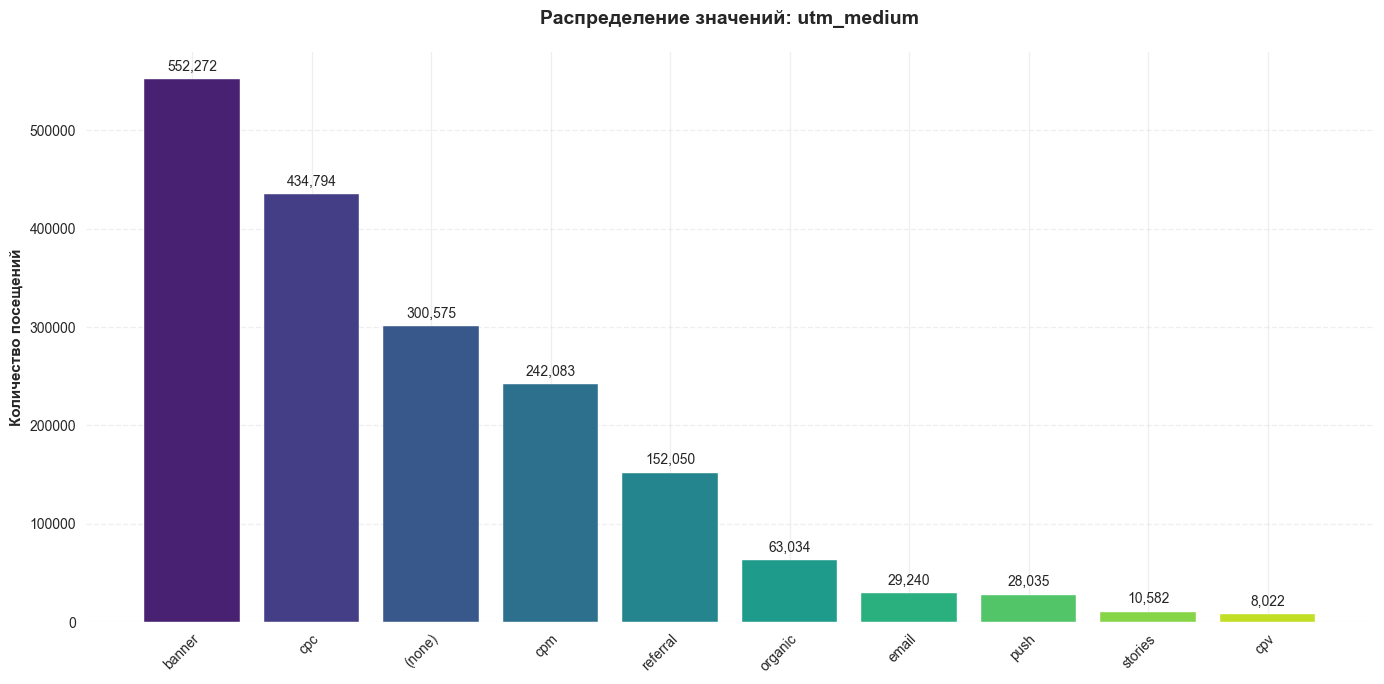


Топ-10 значений для utm_medium:
+------------+--------------+
| Значение   |   Количество |
+============+==============+
| banner     |       552272 |
+------------+--------------+
| cpc        |       434794 |
+------------+--------------+
| (none)     |       300575 |
+------------+--------------+
| cpm        |       242083 |
+------------+--------------+
| referral   |       152050 |
+------------+--------------+
| organic    |        63034 |
+------------+--------------+
| email      |        29240 |
+------------+--------------+
| push       |        28035 |
+------------+--------------+
| stories    |        10582 |
+------------+--------------+
| cpv        |         8022 |
+------------+--------------+




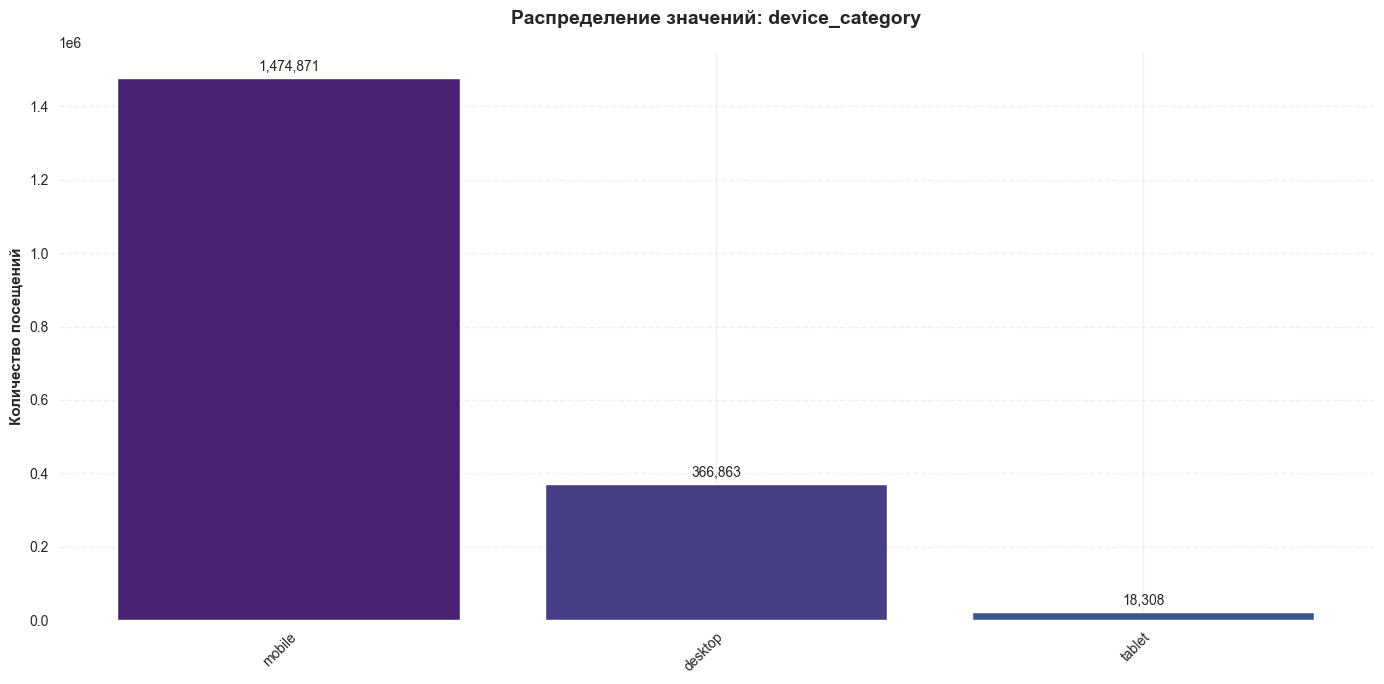


Топ-10 значений для device_category:
+------------+------------------+
| Значение   |       Количество |
+============+==================+
| mobile     |      1.47487e+06 |
+------------+------------------+
| desktop    | 366863           |
+------------+------------------+
| tablet     |  18308           |
+------------+------------------+




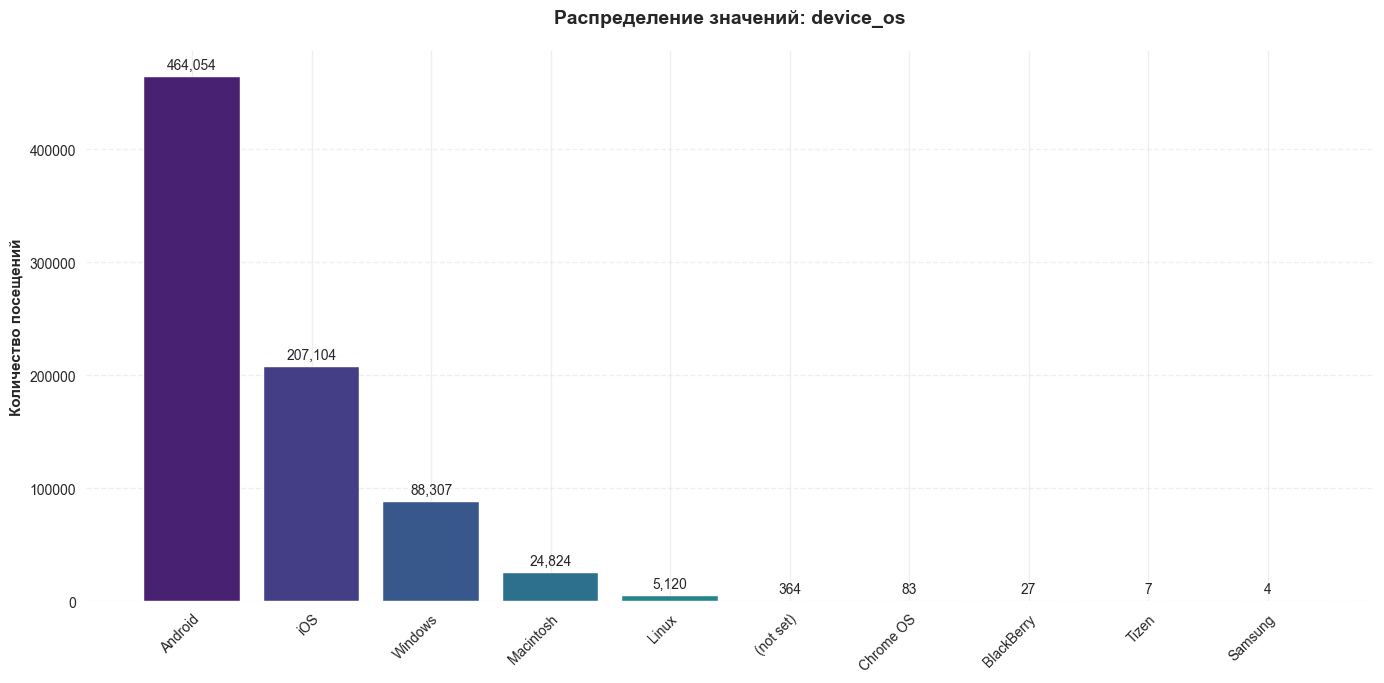


Топ-10 значений для device_os:
+------------+--------------+
| Значение   |   Количество |
+============+==============+
| Android    |       464054 |
+------------+--------------+
| iOS        |       207104 |
+------------+--------------+
| Windows    |        88307 |
+------------+--------------+
| Macintosh  |        24824 |
+------------+--------------+
| Linux      |         5120 |
+------------+--------------+
| (not set)  |          364 |
+------------+--------------+
| Chrome OS  |           83 |
+------------+--------------+
| BlackBerry |           27 |
+------------+--------------+
| Tizen      |            7 |
+------------+--------------+
| Samsung    |            4 |
+------------+--------------+




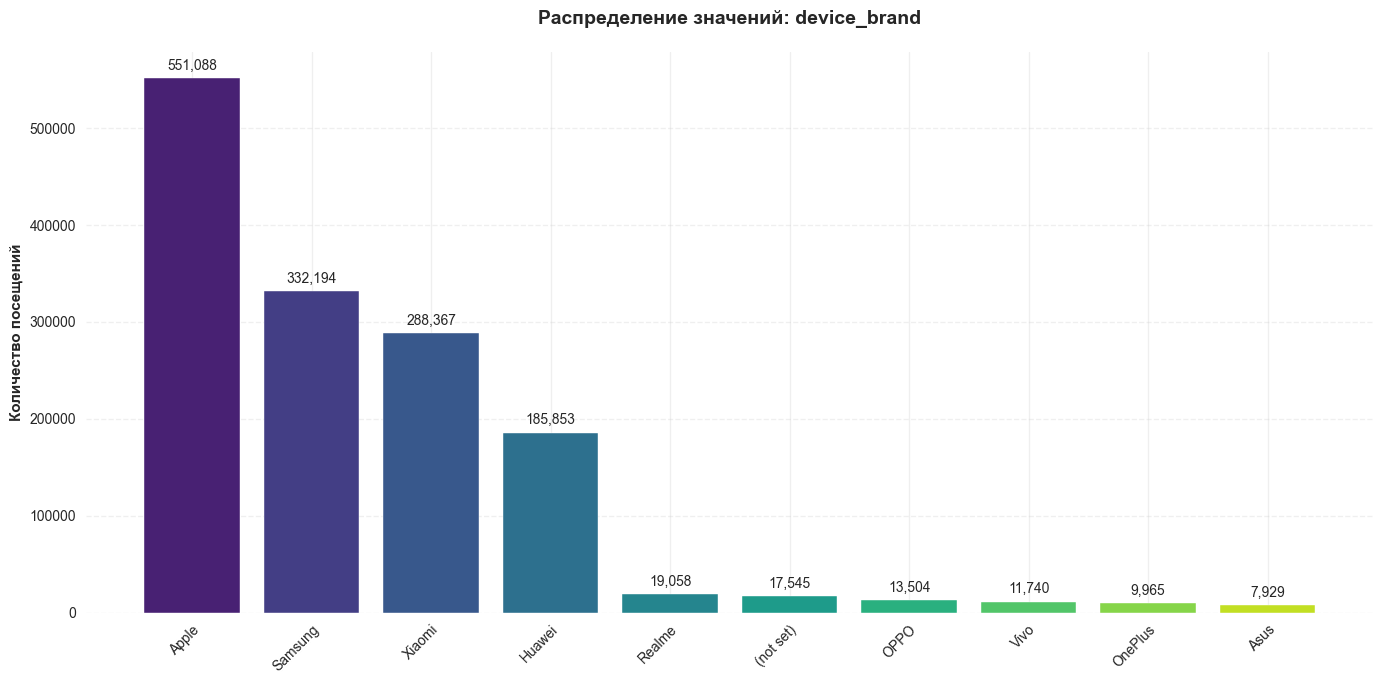


Топ-10 значений для device_brand:
+------------+--------------+
| Значение   |   Количество |
+============+==============+
| Apple      |       551088 |
+------------+--------------+
| Samsung    |       332194 |
+------------+--------------+
| Xiaomi     |       288367 |
+------------+--------------+
| Huawei     |       185853 |
+------------+--------------+
| Realme     |        19058 |
+------------+--------------+
| (not set)  |        17545 |
+------------+--------------+
| OPPO       |        13504 |
+------------+--------------+
| Vivo       |        11740 |
+------------+--------------+
| OnePlus    |         9965 |
+------------+--------------+
| Asus       |         7929 |
+------------+--------------+




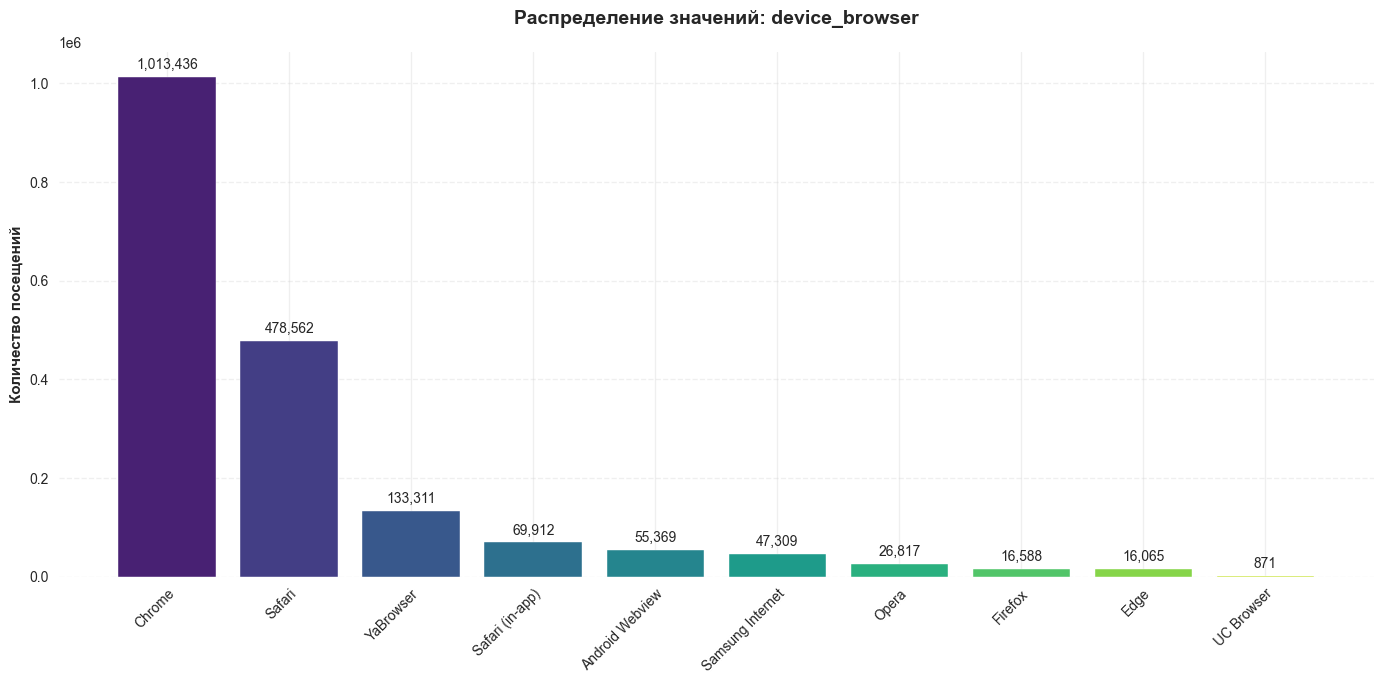


Топ-10 значений для device_browser:
+------------------+------------------+
| Значение         |       Количество |
+==================+==================+
| Chrome           |      1.01344e+06 |
+------------------+------------------+
| Safari           | 478562           |
+------------------+------------------+
| YaBrowser        | 133311           |
+------------------+------------------+
| Safari (in-app)  |  69912           |
+------------------+------------------+
| Android Webview  |  55369           |
+------------------+------------------+
| Samsung Internet |  47309           |
+------------------+------------------+
| Opera            |  26817           |
+------------------+------------------+
| Firefox          |  16588           |
+------------------+------------------+
| Edge             |  16065           |
+------------------+------------------+
| UC Browser       |    871           |
+------------------+------------------+




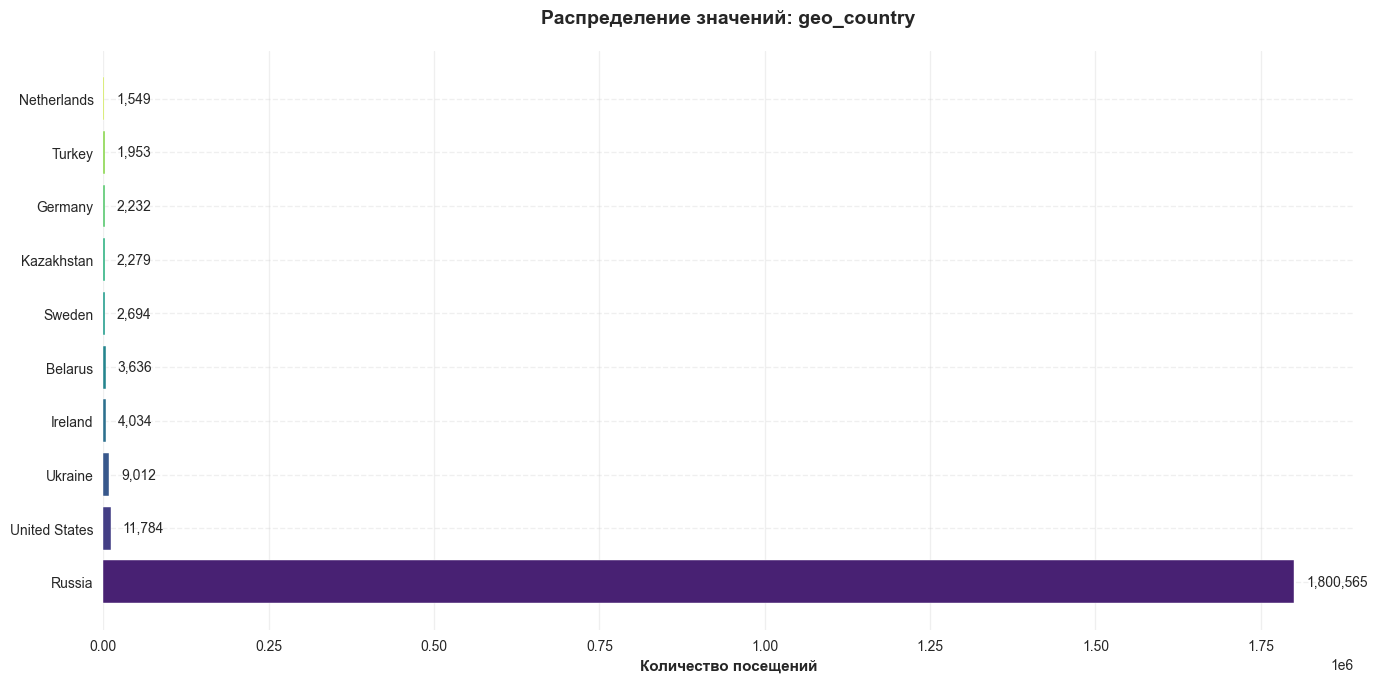


Топ-10 значений для geo_country:
+---------------+-----------------+
| Значение      |      Количество |
+===============+=================+
| Russia        |     1.80056e+06 |
+---------------+-----------------+
| United States | 11784           |
+---------------+-----------------+
| Ukraine       |  9012           |
+---------------+-----------------+
| Ireland       |  4034           |
+---------------+-----------------+
| Belarus       |  3636           |
+---------------+-----------------+
| Sweden        |  2694           |
+---------------+-----------------+
| Kazakhstan    |  2279           |
+---------------+-----------------+
| Germany       |  2232           |
+---------------+-----------------+
| Turkey        |  1953           |
+---------------+-----------------+
| Netherlands   |  1549           |
+---------------+-----------------+




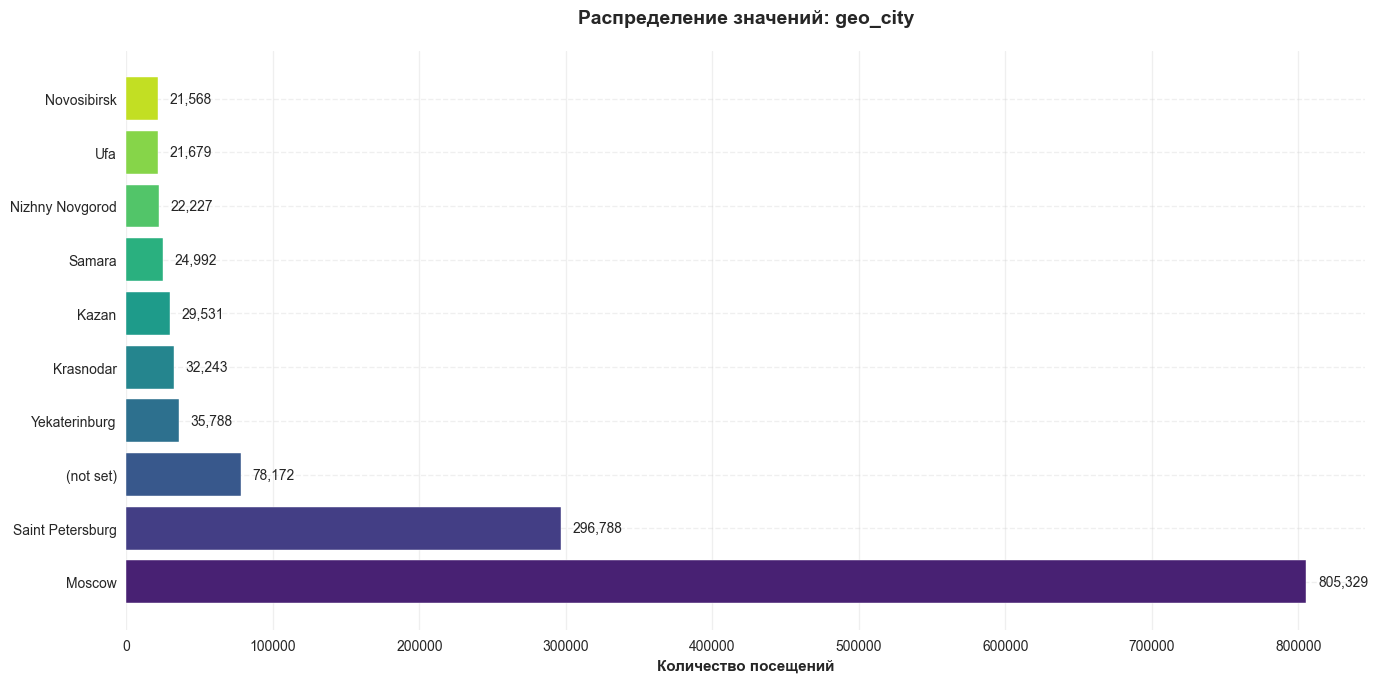


Топ-10 значений для geo_city:
+------------------+--------------+
| Значение         |   Количество |
+==================+==============+
| Moscow           |       805329 |
+------------------+--------------+
| Saint Petersburg |       296788 |
+------------------+--------------+
| (not set)        |        78172 |
+------------------+--------------+
| Yekaterinburg    |        35788 |
+------------------+--------------+
| Krasnodar        |        32243 |
+------------------+--------------+
| Kazan            |        29531 |
+------------------+--------------+
| Samara           |        24992 |
+------------------+--------------+
| Nizhny Novgorod  |        22227 |
+------------------+--------------+
| Ufa              |        21679 |
+------------------+--------------+
| Novosibirsk      |        21568 |
+------------------+--------------+




In [ ]:
!pip install tabulate

# Настройка стиля графиков (актуальная версия)
plt.style.use('seaborn-v0_8')  
sns.set_style("whitegrid")  


plt.rcParams.update({
    'figure.figsize': (14, 7),
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'grid.alpha': 0.3
})

# Список столбцов для анализа
columns = ['utm_medium', 'device_category', 'device_os', 'device_brand', 
           'device_browser', 'geo_country', 'geo_city']

# Цветовая палитра
palette = sns.color_palette("viridis", n_colors=10)

# Построение графиков для каждого столбца
for column in columns:
    # Получаем топ-10 значений
    top10 = df_sessions[column].value_counts().head(10)
    
    # Создаем фигуру
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Определяем тип графика
    horizontal = column in ['geo_country', 'geo_city']
    
    if horizontal:
        bars = ax.barh(top10.index, top10.values, color=palette)
        ax.set_xlabel('Количество посещений', fontweight='bold')
        ax.set_ylabel('')
        
        # Добавляем значения справа от столбцов
        for bar in bars:
            width = bar.get_width()
            ax.text(width + max(top10.values)*0.01,
                    bar.get_y() + bar.get_height()/2,
                    f'{int(width):,}',
                    va='center', ha='left', fontsize=10)
    else:
        bars = ax.bar(top10.index, top10.values, color=palette)
        ax.set_ylabel('Количество посещений', fontweight='bold')
        ax.set_xlabel('')
        
        # Добавляем значения сверху столбцов
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.,
                    height + max(top10.values)*0.01,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=10)
        
        plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # Настройка внешнего вида
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.title(f'Распределение значений: {column}', pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()

    # Выводим таблицу с данными
    print(f"\nТоп-10 значений для {column}:")
    print(top10.to_markdown(tablefmt="grid", headers=["Значение", "Количество"]))
    print("\n" + "="*100 + "\n")

Из приведенных выше графиков очевидно, что наболее популярный способ входа на сайт - мобильные телефоны.
В свою очередь в разрезе мобильных устройств лидирующие позиции занимают утсройства Apple и Samsung.
Наибольшее число обращений к сайту в георграфическом плане - и Москвы и Санкт-Петербурга.
Таким образом портрет типичного посетителя сайта: житель города-миллионника, активно использующий современные технологии.

In [14]:
pd.crosstab(df_sessions['utm_keyword'].isna(), df_sessions['device_os'].isna())

device_os,False,True
utm_keyword,,
False,777981,0
True,11923,1070138


Сильная зависимость пропусков:
когда utm_keyword заполнено → device_os тоже всегда заполнено (0 пропусков в строке utm_keyword=False).

Это значит, что если рекламное ключевое слово известно, то операционная система устройства тоже всегда записана.

*Возможно, что данные об ОС собираются только для трафика с UTM-метками (например, рекламные клики).*

Когда utm_keyword пропущено → device_os чаще всего тоже пропущено (1,070,138 случаев).

Но есть исключения: 11,923 случая, где utm_keyword пропущено, а device_os — нет.

*Возможно, что часть трафика (например, прямой или органический) не имеет UTM-меток, но ОС всё равно фиксируется.*

In [15]:
pd.crosstab(df_sessions['utm_adcontent'].isna(), df_sessions['device_brand'].isna())

device_brand,False,True
utm_adcontent,,
False,1246503,277924
True,246361,89254


Сильная корреляция пропусков:

* Когда utm_adcontent заполнен, device_brand чаще тоже заполнен (1.2M vs 277K пропусков).
* Но есть исключения: в 246K случаях бренд есть, а рекламный контент отсутствует.

Возможные причины пропусков:

Для device_brand:

  * Пропуски могут быть у дешёвых/неизвестных устройств или при ограниченных данных (например, iOS скрывает бренд).

Для utm_adcontent:

  * Пустые значения характерны для органического трафика или кампаний без детализации.

Рекламные клики (utm_adcontent заполнен):

  * Чаще всего известен и бренд устройства (вероятно, из-за точного трекинга).



In [16]:
pd.crosstab(df_sessions['utm_keyword'].isna(), df_sessions['utm_adcontent'].isna())

utm_adcontent,False,True
utm_keyword,,
False,680384,97597
True,844043,238018


 58% событий (1,082,061/1,860,042) не содержат UTM-ключевых слов. При этом 72% событий без utm_keyword (844,043/1,082,061) имеют заполненный utm_adcontent, что указывает на неполную разметку рекламных кампаний

⏳ Анализ временных характеристик сессий:


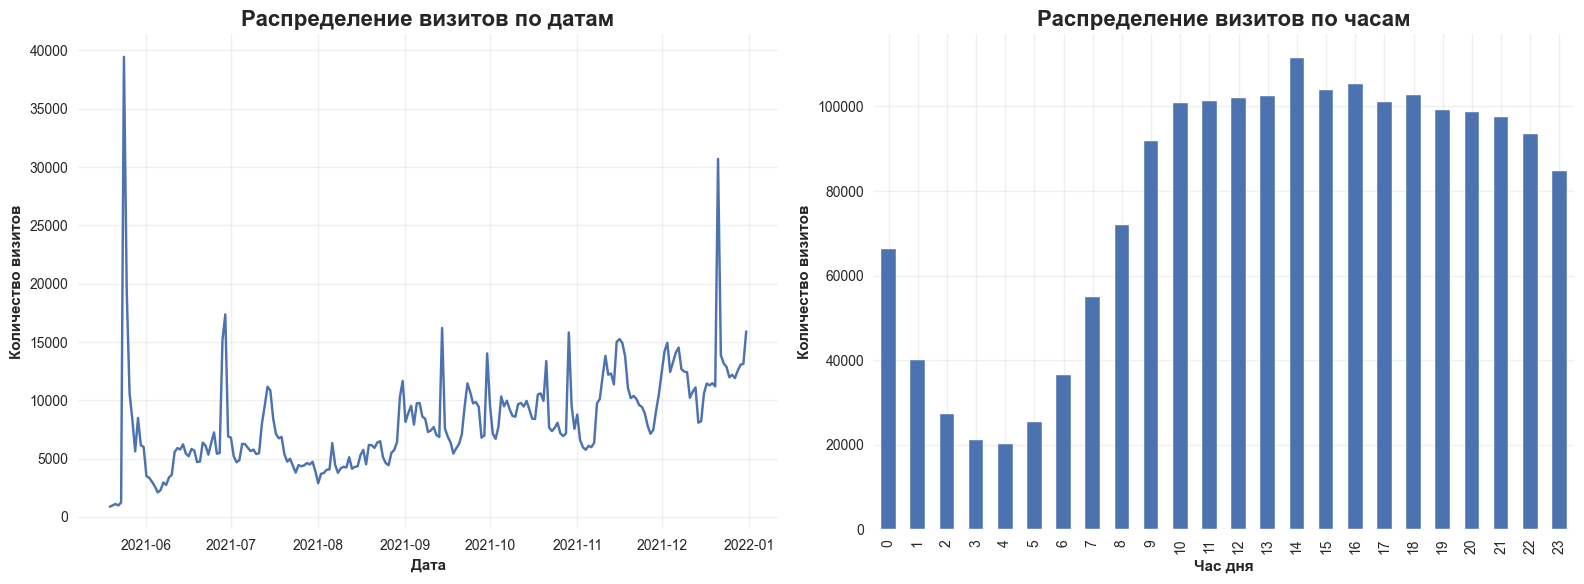

In [ ]:
# 3. Анализ временных характеристик сессий
print("⏳ Анализ временных характеристик сессий:")
df_sessions['visit_datetime'] = pd.to_datetime(df_sessions['visit_date'].astype(str) + ' ' + df_sessions['visit_time'].astype(str))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
df_sessions['visit_datetime'].dt.date.value_counts().sort_index().plot()
plt.title("Распределение визитов по датам")
plt.xlabel("Дата")
plt.ylabel("Количество визитов")

plt.subplot(1, 2, 2)
df_sessions['visit_datetime'].dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title("Распределение визитов по часам")
plt.xlabel("Час дня")
plt.ylabel("Количество визитов")
plt.tight_layout()
plt.show()


Из анализа приведенных графиков видно, что пик посещаемости сайта приходится на рабочее и вечернее время. В долгосрочной перспективе видим общую тенденцию увеличения посещаемости с локальными всплексами и падениями

📢 Анализ каналов привлечения:


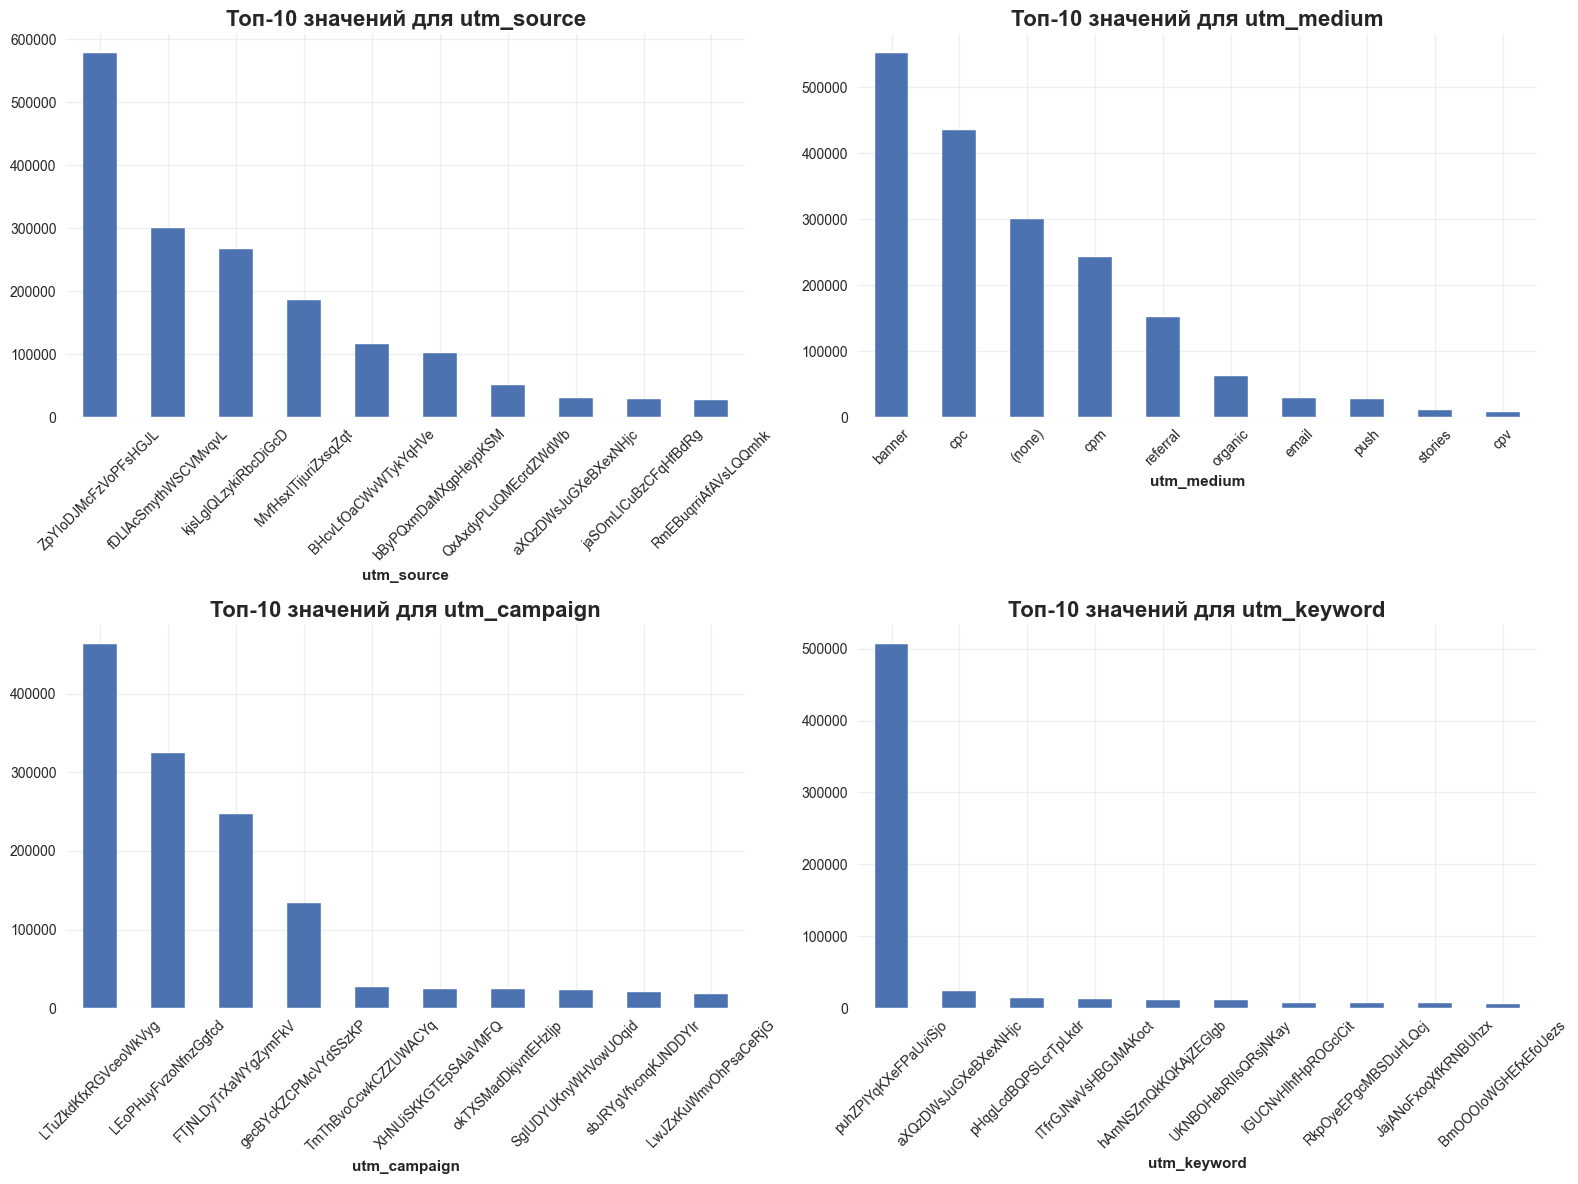

In [18]:
# Анализ каналов привлечения
print("📢 Анализ каналов привлечения:")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

utm_cols = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_keyword']
for i, col in enumerate(utm_cols):
    ax = axes[i//2, i%2]
    df_sessions[col].value_counts().head(10).plot(kind='bar', ax=ax)
    ax.set_title(f"Топ-10 значений для {col}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Для значения utm_medium видим, что наиболее весомый вклад в привлчение посетителей у баннера, cpc, cpm и реферальной ссылки.
Поскольну данные по utm_source, utm_campaign, utm_keyword захешированы, то требуется запросить дополнительные данные (расщифровку)


# Объединение таблиц - df_merged

In [21]:
# Анализ размеров таблиц перед объединением
print("АНАЛИЗ РАЗМЕРОВ ТАБЛИЦ:")
print("=" * 40)

sessions_shape = df_sessions.shape
hits_shape = df_hits.shape

print(f"📊 Размеры таблиц:")
print(f"  df_sessions: {sessions_shape[0]:,} строк × {sessions_shape[1]} столбцов")
print(f"  df_hits: {hits_shape[0]:,} строк × {hits_shape[1]} столбцов")
print(f"  Разница в строках: {hits_shape[0] - sessions_shape[0]:,}")

# Анализ ключей объединения
sessions_ids = set(df_sessions['session_id'].unique())
hits_ids = set(df_hits['session_id'].unique())

print(f"\n🔑 Уникальные session_id:")
print(f"  В sessions: {len(sessions_ids):,}")
print(f"  В hits: {len(hits_ids):,}")

# Анализ пересечений
common_ids = sessions_ids.intersection(hits_ids)
sessions_only = sessions_ids - hits_ids
hits_only = hits_ids - sessions_ids

print(f"\n🔗 Пересечения:")
print(f"  Общие session_id: {len(common_ids):,}")
print(f"  Только в sessions: {len(sessions_only):,}")
print(f"  Только в hits: {len(hits_only):,}")

# Покрытие
coverage_sessions = len(common_ids) / len(sessions_ids) * 100
coverage_hits = len(common_ids) / len(hits_ids) * 100

print(f"\n📈 Покрытие:")
print(f"  Сессии с событиями: {coverage_sessions:.1f}%")
print(f"  События с сессиями: {coverage_hits:.1f}%")

# Статистика событий на сессию
hits_per_session = df_hits['session_id'].value_counts()
print(f"\n📊 События на сессию:")
print(f"  Среднее: {hits_per_session.mean():.1f}")
print(f"  Медиана: {hits_per_session.median():.1f}")
print(f"  Максимум: {hits_per_session.max():,}")
print(f"  Минимум: {hits_per_session.min()}")

АНАЛИЗ РАЗМЕРОВ ТАБЛИЦ:
📊 Размеры таблиц:
  df_sessions: 1,860,042 строк × 19 столбцов
  df_hits: 15,726,470 строк × 11 столбцов
  Разница в строках: 13,866,428

🔑 Уникальные session_id:
  В sessions: 1,860,042
  В hits: 1,734,610

🔗 Пересечения:
  Общие session_id: 1,732,266
  Только в sessions: 127,776
  Только в hits: 2,344

📈 Покрытие:
  Сессии с событиями: 93.1%
  События с сессиями: 99.9%

📊 События на сессию:
  Среднее: 9.1
  Медиана: 4.0
  Максимум: 768
  Минимум: 1


In [22]:
# import pyarrow - если надо в формате parquete
# Объединение таблиц
# Используем left join, так как хотим сохранить все строки из df_hits_clean
df_merged = pd.merge(
    df_hits,
    df_sessions,
    on='session_id',
    how='left',  # left join - сохраняем все строки из левой таблицы (hits)
    suffixes=('_hit', '_session')  # суффиксы для одинаковых названий столбцов
)

# Проверка результата
print(f"Исходное количество строк в df_hits: {len(df_hits)}")
print(f"Количество строк после объединения: {len(df_merged)}")
print("\nПервые 5 строк объединенной таблицы:")
display(df_merged.head())

# Сохранение результата
output_path = 'C:/Users/Starintseva/Documents/df_merged.csv'
#df_merged.to_parquet(output_path, engine='pyarrow')
# вместо Parquet — обычный CSV
# df_merged.to_csv(output_path, index=False)
print(f"\nОбъединенная таблица сохранена в: {output_path}")

Исходное количество строк в df_hits: 15726470
Количество строк после объединения: 15726470

Первые 5 строк объединенной таблицы:


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,...,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,visit_datetime
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,...,wvtWRwiRmvPIsSQuXnvd,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Saint Petersburg,2021-12-23 13:07:36
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,...,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk,2021-12-23 17:51:49
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,...,JajANoFxoqXfKRNBUhzx,desktop,Windows,NaN,NaN,2560x1080,Chrome,Russia,Moscow,2021-12-23 08:03:27
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,...,zXjuoqEaPElBnwpSHMpx,mobile,Android,Samsung,NaN,412x915,Chrome,Russia,Podolsk,2021-12-23 01:10:14
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,...,puhZPIYqKXeFPaUviSjo,desktop,Windows,NaN,NaN,1536x864,Chrome,Estonia,Tallinn,2021-12-23 16:11:18



Объединенная таблица сохранена в: C:/Users/Starintseva/Documents/df_merged.csv


In [23]:
# Анализ размеров таблиц перед объединением
print("АНАЛИЗ РАЗМЕРОВ ТАБЛИЦ:")
print("=" * 40)

sessions_shape = df_sessions.shape
hits_shape = df_hits.shape

print(f"📊 Размеры таблиц:")
print(f"  df_sessions: {sessions_shape[0]:,} строк × {sessions_shape[1]} столбцов")
print(f"  df_hits: {hits_shape[0]:,} строк × {hits_shape[1]} столбцов")
print(f"  Разница в строках: {hits_shape[0] - sessions_shape[0]:,}")

# Анализ ключей объединения
sessions_ids = set(df_sessions['session_id'].unique())
hits_ids = set(df_hits['session_id'].unique())

print(f"\n🔑 Уникальные session_id:")
print(f"  В sessions: {len(sessions_ids):,}")
print(f"  В hits: {len(hits_ids):,}")

# Анализ пересечений
common_ids = sessions_ids.intersection(hits_ids)
sessions_only = sessions_ids - hits_ids
hits_only = hits_ids - sessions_ids

print(f"\n🔗 Пересечения:")
print(f"  Общие session_id: {len(common_ids):,}")
print(f"  Только в sessions: {len(sessions_only):,}")
print(f"  Только в hits: {len(hits_only):,}")

# Покрытие
coverage_sessions = len(common_ids) / len(sessions_ids) * 100
coverage_hits = len(common_ids) / len(hits_ids) * 100

print(f"\n📈 Покрытие:")
print(f"  Сессии с событиями: {coverage_sessions:.1f}%")
print(f"  События с сессиями: {coverage_hits:.1f}%")

# Статистика событий на сессию
hits_per_session = df_hits['session_id'].value_counts()
print(f"\n📊 События на сессию:")
print(f"  Среднее: {hits_per_session.mean():.1f}")
print(f"  Медиана: {hits_per_session.median():.1f}")
print(f"  Максимум: {hits_per_session.max():,}")
print(f"  Минимум: {hits_per_session.min()}")

АНАЛИЗ РАЗМЕРОВ ТАБЛИЦ:
📊 Размеры таблиц:
  df_sessions: 1,860,042 строк × 19 столбцов
  df_hits: 15,726,470 строк × 11 столбцов
  Разница в строках: 13,866,428

🔑 Уникальные session_id:
  В sessions: 1,860,042
  В hits: 1,734,610

🔗 Пересечения:
  Общие session_id: 1,732,266
  Только в sessions: 127,776
  Только в hits: 2,344

📈 Покрытие:
  Сессии с событиями: 93.1%
  События с сессиями: 99.9%

📊 События на сессию:
  Среднее: 9.1
  Медиана: 4.0
  Максимум: 768
  Минимум: 1


In [24]:
%%script false --no-raise-error
# Эта ячейка не выполнится
print("Этот код не запустится")

file_path = r'C:/Users/Starintseva/Documents/df_merged.csv'

try:
    # Загрузка данных
    df_merged = pd.read_csv(file_path)
    
    # Проверка данных (первые 5 строк)
    print("Данные успешно загружены! Первые 5 строк:")
    print(df_merged.head())
    
    # Дополнительная информация о данных (столбцы, типы данных)
    print("\nИнформация о данных:")
    print(df_merged.info())
    
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути {file_path}")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Couldn't find program: 'false'


In [25]:
# Дополнительная информация о данных (столбцы, типы данных)
print("\nИнформация о данных:")
print(df_merged.info())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 29 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   hit_date                  object        
 2   hit_time                  float64       
 3   hit_number                int64         
 4   hit_type                  object        
 5   hit_referer               object        
 6   hit_page_path             object        
 7   event_category            object        
 8   event_action              object        
 9   event_label               object        
 10  event_value               float64       
 11  client_id                 object        
 12  visit_date                object        
 13  visit_time                object        
 14  visit_number              float64       
 15  utm_source                object        
 16  utm_medium                obje

In [26]:
# Проверка дубликатов после объединения файлов
merged_duplicates = df_merged.duplicated(subset=['session_id', 'hit_number']).sum()

print(f"Дубликаты в объединенном: {merged_duplicates}")

Дубликаты в объединенном: 225862


1. Анализ по устройствам:


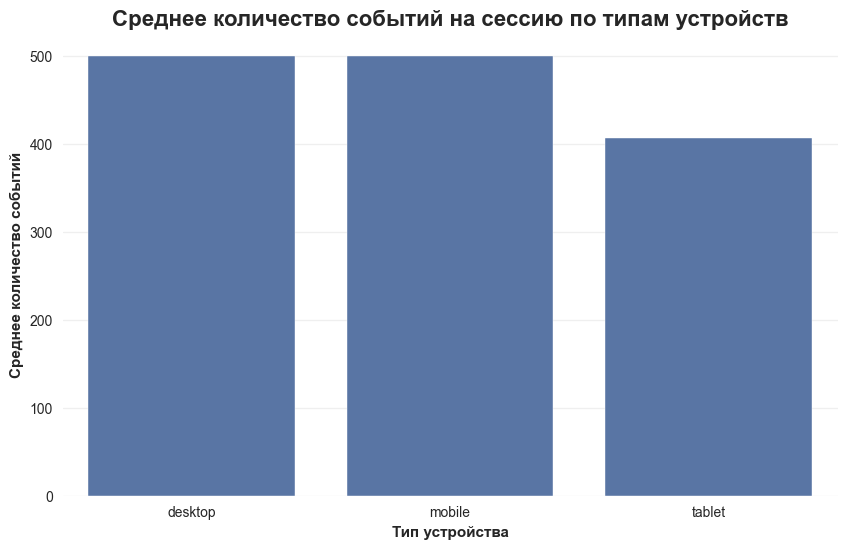


2. Анализ популярности страниц и событий:


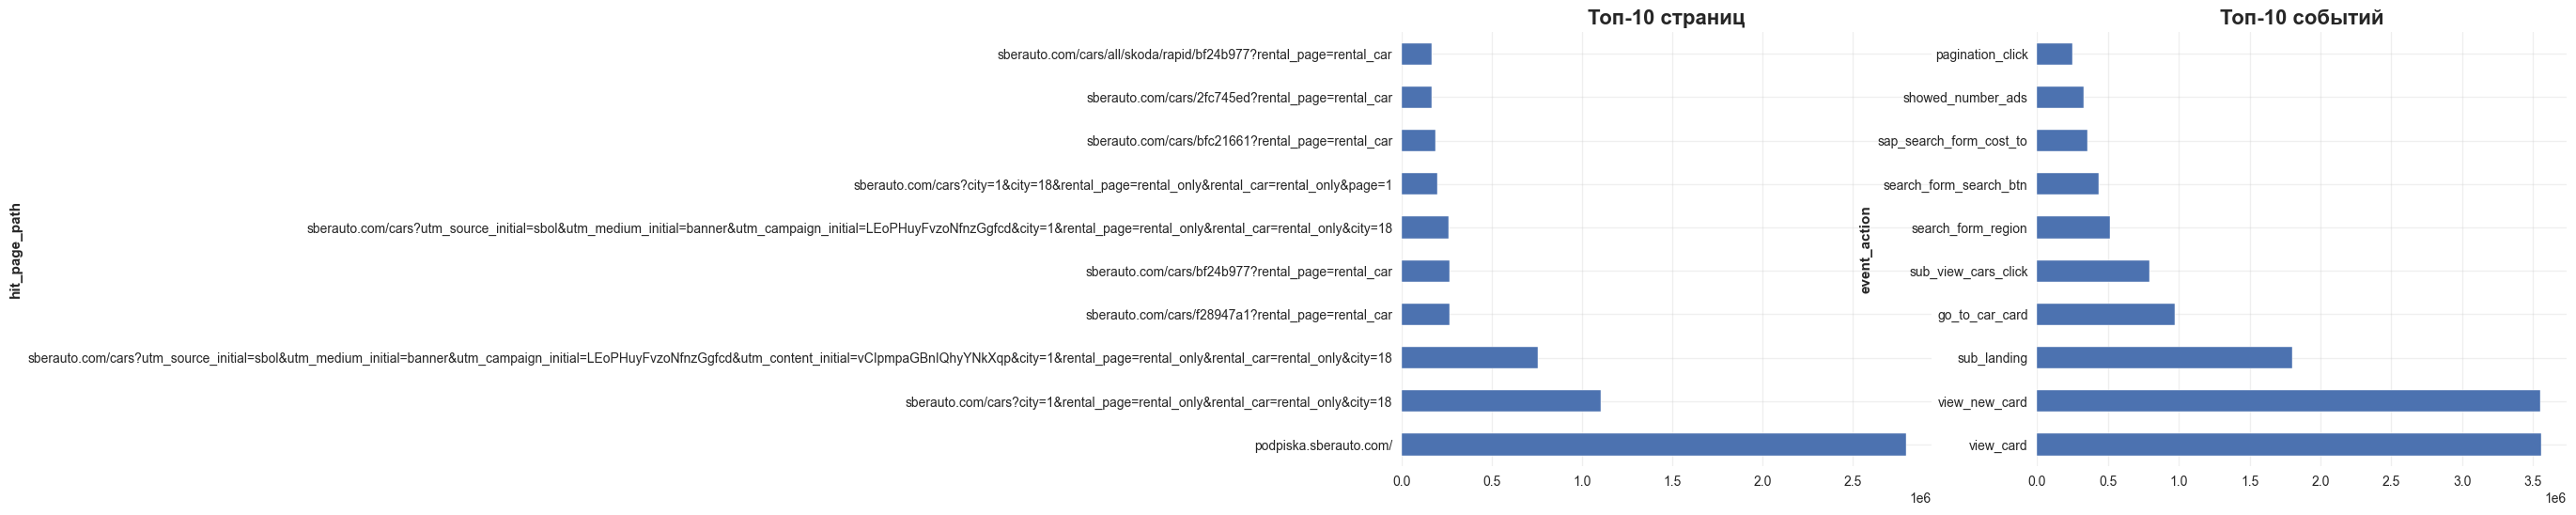


3. Анализ временных паттернов:


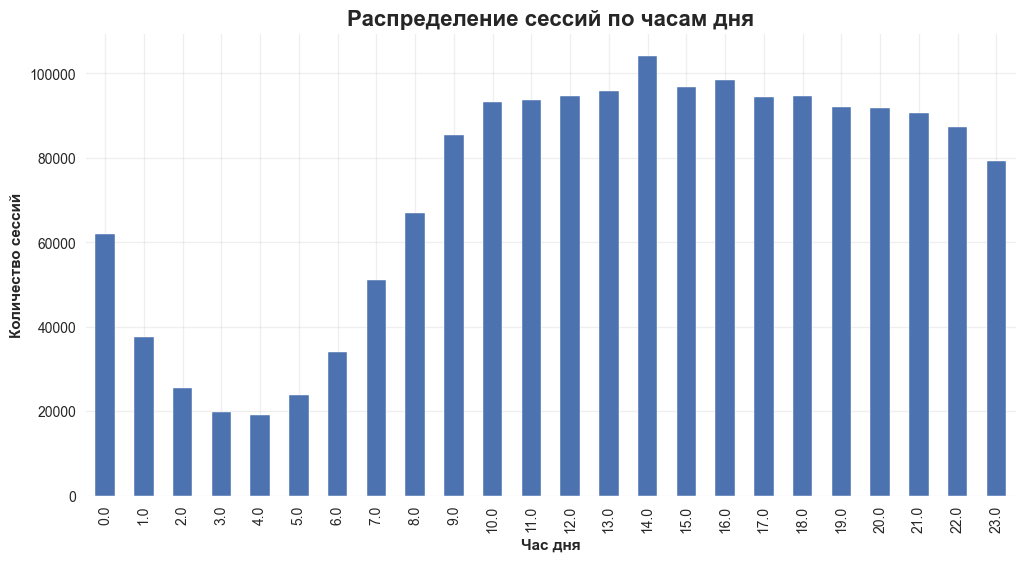


4. Анализ последовательностей страниц:
Топ-10 переходов между страницами:
podpiska.sberauto.com/ → podpiska.sberauto.com/: 542 раз
sberauto.com/cars?city=1&rental_page=rental_only&rental_car=rental_only&city=18 → sberauto.com/cars?city=1&rental_page=rental_only&rental_car=rental_only&city=18: 312 раз
sberauto.com/cars?utm_source_initial=sbol&utm_medium_initial=banner&utm_campaign_initial=LEoPHuyFvzoNfnzGgfcd&utm_content_initial=vCIpmpaGBnIQhyYNkXqp&city=1&rental_page=rental_only&rental_car=rental_only&city=18 → sberauto.com/cars?utm_source_initial=sbol&utm_medium_initial=banner&utm_campaign_initial=LEoPHuyFvzoNfnzGgfcd&utm_content_initial=vCIpmpaGBnIQhyYNkXqp&city=1&rental_page=rental_only&rental_car=rental_only&city=18: 249 раз
sberauto.com/cars/nissan?rental_car=rental_only&rental_page=rental_only → sberauto.com/cars/nissan?rental_car=rental_only&rental_page=rental_only: 160 раз
sberauto.com/cars/f28947a1?rental_page=rental_car → sberauto.com/cars/f28947a1?rental_page=rental_car: 15

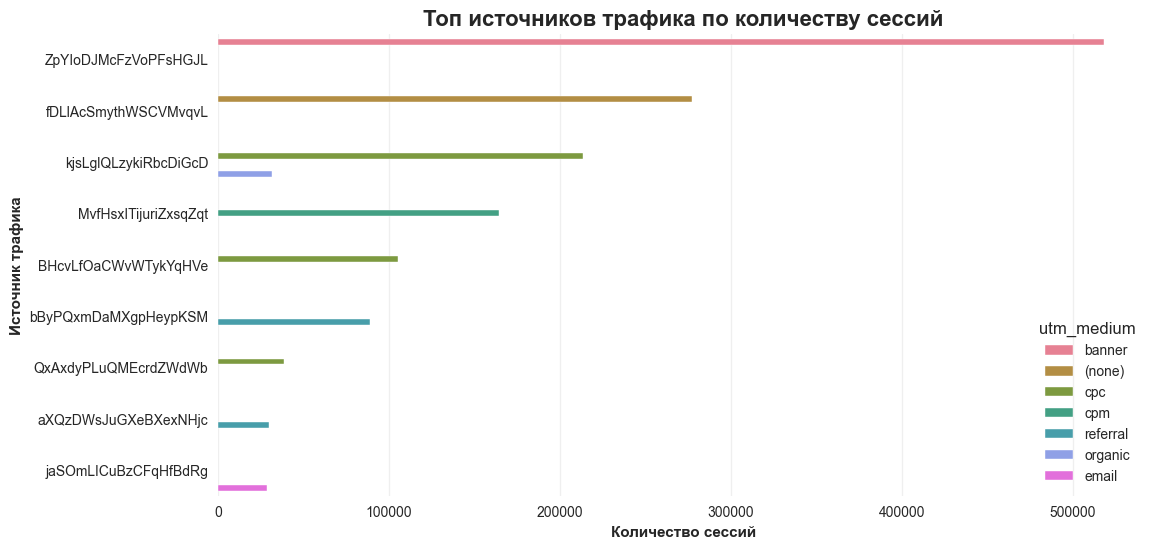

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# 1. Анализ распределения событий по типам устройств
def device_events_analysis(df_merged):
    device_analysis = df_merged.groupby('device_category').agg(
        total_sessions=('session_id', 'nunique'),
        avg_events_per_session=('hit_number', lambda x: x.max().mean())
    ).reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=device_analysis, x='device_category', y='avg_events_per_session')
    plt.title('Среднее количество событий на сессию по типам устройств')
    plt.ylabel('Среднее количество событий')
    plt.xlabel('Тип устройства')
    plt.show()
    
    return device_analysis

# 2. Анализ популярности страниц и событий
def popularity_analysis(df_merged, top_n=10):
    # Топ страниц
    top_pages = df_merged['hit_page_path'].value_counts().head(top_n)
    
    # Топ событий
    top_events = df_merged['event_action'].value_counts().head(top_n)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    top_pages.plot(kind='barh', ax=ax1, title=f'Топ-{top_n} страниц')
    top_events.plot(kind='barh', ax=ax2, title=f'Топ-{top_n} событий')
    
    plt.tight_layout()
    plt.show()
    
    return top_pages, top_events

# 3. Анализ временных паттернов
def time_patterns_analysis(df_merged):
    # Преобразуем время визита
    df_merged['visit_hour'] = pd.to_datetime(df_merged['visit_time']).dt.hour
    
    # Распределение по часам
    hourly_dist = df_merged.groupby('visit_hour')['session_id'].nunique()
    
    plt.figure(figsize=(12, 6))
    hourly_dist.plot(kind='bar')
    plt.title('Распределение сессий по часам дня')
    plt.xlabel('Час дня')
    plt.ylabel('Количество сессий')
    plt.show()
    
    return hourly_dist

# 4. Анализ последовательностей страниц
def path_sequence_analysis(df_merged, sample_size=1000):
    # Берем случайную выборку сессий для анализа
    sample_sessions = df_merged['session_id'].drop_duplicates().sample(sample_size)
    sample_df = df_merged[df_merged['session_id'].isin(sample_sessions)]
    
    # Собираем последовательности
    paths = sample_df.groupby('session_id')['hit_page_path'].apply(list)
    
    # Анализируем частые переходы
    transitions = Counter()
    for path in paths:
        for i in range(len(path)-1):
            transition = (path[i], path[i+1])
            transitions[transition] += 1
    
    # Топ-10 переходов
    top_transitions = transitions.most_common(10)
    
    print("Топ-10 переходов между страницами:")
    for (from_page, to_page), count in top_transitions:
        print(f"{from_page} → {to_page}: {count} раз")
    
    return top_transitions

# 5. Анализ источников трафика
def traffic_source_analysis(df_merged):
    source_analysis = df_merged.groupby(['utm_source', 'utm_medium']).agg(
        sessions=('session_id', 'nunique'),
        avg_events=('hit_number', 'max')
    ).reset_index().sort_values('sessions', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=source_analysis.head(10), x='sessions', y='utm_source', hue='utm_medium')
    plt.title('Топ источников трафика по количеству сессий')
    plt.xlabel('Количество сессий')
    plt.ylabel('Источник трафика')
    plt.show()
    
    return source_analysis

# Главная функция для запуска анализа
def run_analysis(df_merged):
    print("1. Анализ по устройствам:")
    device_stats = device_events_analysis(df_merged)

    print("\n2. Анализ популярности страниц и событий:")
    top_pages, top_events = popularity_analysis(df_merged)

    print("\n3. Анализ временных паттернов:")
    hourly_stats = time_patterns_analysis(df_merged)

    print("\n4. Анализ последовательностей страниц:")
    common_transitions = path_sequence_analysis(df_merged)

    print("\n5. Анализ источников трафика:")
    traffic_stats = traffic_source_analysis(df_merged)
    
    return {
        'device_stats': device_stats,
        'top_pages': top_pages,
        'top_events': top_events,
        'hourly_stats': hourly_stats,
        'common_transitions': common_transitions,
        'traffic_stats': traffic_stats
    }

# Запуск анализа (убедитесь, что df_merged уже загружен)
if 'df_merged' in globals():
    results = run_analysis(df_merged)
else:
    print("Ошибка: DataFrame 'df_merged' не найден. Пожалуйста, загрузите данные перед запуском анализа.")


df_merged=df_merged.drop(columns=['visit_hour']) #удаляем временный столбец

# Cоздание нового df - объединенный очищенный

In [28]:
# Создаем копию для очистки
df_merged_clean = df_merged.copy()

# Удаление проблемных столбцов с пропусками
df_merged_clean = df_merged_clean.drop(columns=['hit_date', 'hit_time', 'hit_referer', 'hit_type', 'geo_country', 'event_label', 'event_value', 'device_browser', 'utm_adcontent', 'device_model', 'device_screen_resolution'])

print(f"Удалены столбцы: 'hit_date', 'hit_time', 'hit_referer', 'hit_type', 'geo_country', 'event_label', 'event_value', 'device_browser', 'utm_adcontent', 'device_model', 'device_screen_resolution'")

Удалены столбцы: 'hit_date', 'hit_time', 'hit_referer', 'hit_type', 'geo_country', 'event_label', 'event_value', 'device_browser', 'utm_adcontent', 'device_model', 'device_screen_resolution'


In [29]:
# Объединение даты и времени в datetime
df_merged_clean['visit_datetime'] = pd.to_datetime(
    df_merged_clean['visit_date'] + ' ' + df_merged_clean['visit_time']
)

# Заполнение пропусков в device_os
df_merged_clean['device_os'] = df_merged_clean['device_os'].fillna('unknown')
df_merged_clean['device_os'] = df_merged_clean['device_os'].replace('(not set)', 'unknown')

# Заполнение пропусков в device_brand
df_merged_clean['device_brand'] = df_merged_clean['device_brand'].fillna('other')
df_merged_clean['device_brand'] = df_merged_clean['device_brand'].replace('(not set)', 'other')

print(f"\nРезультат очистки:")
print(f"Форма данных: {df_merged_clean.shape}")
print(f"Добавлены столбцы: visit_datetime")


Результат очистки:
Форма данных: (15726470, 18)
Добавлены столбцы: visit_datetime


In [30]:
print(df_merged_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 18 columns):
 #   Column           Dtype         
---  ------           -----         
 0   session_id       object        
 1   hit_number       int64         
 2   hit_page_path    object        
 3   event_category   object        
 4   event_action     object        
 5   client_id        object        
 6   visit_date       object        
 7   visit_time       object        
 8   visit_number     float64       
 9   utm_source       object        
 10  utm_medium       object        
 11  utm_campaign     object        
 12  utm_keyword      object        
 13  device_category  object        
 14  device_os        object        
 15  device_brand     object        
 16  geo_city         object        
 17  visit_datetime   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(15)
memory usage: 2.1+ GB
None


In [31]:
# Проверка дубликатов
merged_duplicates = df_merged_clean.duplicated(subset=['session_id', 'hit_number']).sum()

print(f"Дубликаты в объединенном: {merged_duplicates}")

Дубликаты в объединенном: 225862


In [32]:
# Удаление дубликатов если есть

df_merged_clean = df_merged_clean.drop_duplicates(subset=['session_id', 'hit_number'])
print(f"Удалено {merged_duplicates} дубликатов всех")

Удалено 225862 дубликатов всех


In [33]:
df_merged_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 15500608 entries, 0 to 15726469
Data columns (total 18 columns):
 #   Column           Non-Null Count     Dtype         
---  ------           --------------     -----         
 0   session_id       15500608 non-null  object        
 1   hit_number       15500608 non-null  int64         
 2   hit_page_path    15500608 non-null  object        
 3   event_category   15500608 non-null  object        
 4   event_action     15500608 non-null  object        
 5   client_id        15459382 non-null  object        
 6   visit_date       15459382 non-null  object        
 7   visit_time       15459382 non-null  object        
 8   visit_number     15459382 non-null  float64       
 9   utm_source       15458682 non-null  object        
 10  utm_medium       15459382 non-null  object        
 11  utm_campaign     13291572 non-null  object        
 12  utm_keyword      6366810 non-null   object        
 13  device_category  15459382 non-null  object   

In [34]:
# Анализ пропусков
missing_sessions = df_merged.isnull().sum()
missing_percent = (missing_sessions / len(df_merged)) * 100

print("Пропуски в сессиях:")
for col, count in missing_sessions[missing_sessions > 0].items():
    print(f"  {col}: {count:,} ({missing_percent[col]:.1f}%)")

Пропуски в сессиях:
  hit_time: 9,160,322 (58.2%)
  hit_referer: 6,274,804 (39.9%)
  event_label: 3,760,184 (23.9%)
  event_value: 15,726,470 (100.0%)
  client_id: 41,251 (0.3%)
  visit_date: 41,251 (0.3%)
  visit_time: 41,251 (0.3%)
  visit_number: 41,251 (0.3%)
  utm_source: 41,951 (0.3%)
  utm_medium: 41,251 (0.3%)
  utm_campaign: 2,240,124 (14.2%)
  utm_adcontent: 2,873,669 (18.3%)
  utm_keyword: 9,246,078 (58.8%)
  device_category: 41,251 (0.3%)
  device_os: 9,199,633 (58.5%)
  device_brand: 3,987,126 (25.4%)
  device_model: 15,604,183 (99.2%)
  device_screen_resolution: 41,251 (0.3%)
  device_browser: 41,251 (0.3%)
  geo_country: 41,251 (0.3%)
  geo_city: 41,251 (0.3%)
  visit_datetime: 41,251 (0.3%)


## Категоризация

In [35]:
print(df_merged_clean['utm_medium'].unique())

['cpc' 'banner' '(none)' 'cpm' 'organic' 'cpa' 'blogger_channel' 'push'
 'referral' nan 'email' 'outlook' 'smm' 'smartbanner' 'sms' 'tg'
 'info_text' 'clicks' '(not set)' 'partner' 'nkp' 'post' 'yandex_cpc'
 'landing' 'CPM' 'cpv' 'ok_smm' 'app' 'link' 'article' 'vk_smm'
 'web_polka' 'blogger_stories' 'landing_interests' 'Sbol_catalog'
 'dom_click' 'users_msk' 'medium' 'static' 'fb_smm' 'main_polka'
 'google_cpc' 'linktest' 'qr' 'promo_sber' 'promo_sbol' 'stories' 'social'
 'last' 'qrcodevideo' 'catalogue' 'sber_app' 'blogger_header' 'cbaafe'
 'reach' 'tablet']


### **Расшифровка значений utm_medium**

| Значение          | Категория               | Описание                                                                 | Пример источника             | Рекомендуемое действие       |
|-------------------|-------------------------|--------------------------------------------------------------------------|-------------------------------|------------------------------|
| `cpc`            | Платный трафик          | Платные клики (контекстная реклама)                                      | Google Ads, Яндекс.Директ     | Оставить как есть            |
| `cpm`            | Платный трафик          | Показная реклама (за 1000 показов)                                       | Рекламные сети, баннеры       | Оставить как есть            |
| `organic`        | Бесплатный трафик       | Органический трафик (без оплаты)                                         | Поисковики, прямые заходы     | Оставить как есть            |
| `referral`       | Бесплатный трафик       | Переходы с других сайтов                                                 | Форумы, партнёрские сайты     | Оставить как есть            |
| `email`          | Маркетинг               | Email-рассылки                                                           | Mailchimp, SendPulse          | Оставить как есть            |
| `(none)`         | Проблемное значение     | Пустое значение или технический сбой                                     | -                             | Заменить на `organic/direct` |
| `(not set)`      | Проблемное значение     | Не задано в UTM-метках                                                   | -                             | Заменить на `direct`         |
| `banner`         | Избыточное значение     | Уточнение для `cpm`                                                      | Баннерные сети                | Объединить с `cpm`           |
| `fb_smm`         | Соцсети                 | Facebook-трафик                                                          | Facebook                      | Объединить с `social`        |
| `google_cpc`     | Дублирующее значение    | Частный случай `cpc`                                                     | Google Ads                    | Объединить с `cpc`           |
| `tg`             | Мессенджеры             | Telegram-трафик                                                          | Telegram                      | Вынести в `messenger`        |
| `sber_app`       | Специфичный источник    | Мобильное приложение Сбера                                               | СберБанк                      | Оставить отдельно            |

In [36]:
# Унификация значений utm_medium
utm_medium_mapping = {
    # Замена пропусков и неопределенных значений
    '(none)': 'direct',
    '(not set)': 'direct',
    'tg': 'direct',
    'fb_smm': 'direct',

    # Объединение похожих каналов
    'banner': 'cpm',
    'google_cpc': 'cpc',

    # Оставляем как есть
    'organic': 'sber_app',
    'organic': 'organic', 
    'cpc': 'cpc',
    'cpm': 'cpm',
    'referral': 'referral',
    'email': 'email'
}

# Применяем маппинг
df_merged_clean['utm_medium'] = df_merged_clean['utm_medium'].map(utm_medium_mapping)

# Заполняем оставшиеся пропуски как 'direct'
df_merged_clean['utm_medium'] = df_merged_clean['utm_medium'].fillna('direct')

# Конвертируем в категориальный тип
df_merged_clean['utm_medium'] = df_merged_clean['utm_medium'].astype('category')

# Проверяем результат
print("Распределение utm_medium после унификации:")
print(df_merged_clean['utm_medium'].value_counts(dropna=False))
print(f"\nВсего уникальных значений: {df_merged_clean['utm_medium'].nunique()}")
print(f"Пропусков: {df_merged_clean['utm_medium'].isnull().sum()}")


Распределение utm_medium после унификации:
utm_medium
cpm         5602213
direct      3944522
cpc         3173691
referral    1898998
organic      641624
email        239560
Name: count, dtype: int64

Всего уникальных значений: 6
Пропусков: 0


In [37]:
def encode_city(city):
    if city == 'Moscow':
        return 'Moscow'
    elif city == 'Saint Petersburg':
        return 'Saint Petersburg'
    else:
        return 'Other'

df_merged_clean['city_group'] = df_merged_clean['geo_city'].apply(encode_city)

df_merged_clean['city_group'] = df_merged_clean['city_group'].astype('category')

In [38]:
print(df_merged_clean['city_group'].unique())

['Saint Petersburg', 'Other', 'Moscow']
Categories (3, object): ['Moscow', 'Other', 'Saint Petersburg']


In [39]:
print(df_merged_clean['city_group'].value_counts(dropna=False))

city_group
Moscow              6685298
Other               6487897
Saint Petersburg    2327413
Name: count, dtype: int64


In [40]:
count_city_group = df_merged_clean['city_group'].count()
print(f"Всего записей в city_group: {count_city_group}")

count_city_group = df_merged_clean['city_group'].value_counts().sum()
print(f"Всего записей в city_group: {count_city_group}")

total_rows = len(df_merged_clean['city_group'])
print(f"Всего строк в city_group (включая пустые): {total_rows}")

unique_count = df_merged_clean['city_group'].nunique()
print(f"Уникальных значений в city_group: {unique_count}")

Всего записей в city_group: 15500608
Всего записей в city_group: 15500608
Всего строк в city_group (включая пустые): 15500608
Уникальных значений в city_group: 3


In [41]:
df_merged_clean = df_merged_clean.drop(columns=['geo_city']) 

In [42]:
### Категоризация типа устройства с которого вошел пользователь. Создаем новую фичу Device

# 1. desktop
desktop_mask = df_merged_clean['device_category'] == 'desktop'

# 2. топ-4 бренда
top_brands = {'Apple', 'Samsung', 'Xiaomi', 'Huawei'}
brand_mask = df_merged_clean['device_brand'].isin(top_brands)

# 3. финальный вектор
device = np.where(
    desktop_mask, 'desktop',
    np.where(brand_mask, df_merged_clean['device_brand'], 'Other')
)

df_merged_clean['Device'] = pd.Categorical(device)

In [43]:
print(df_merged_clean['Device'].unique())

print(df_merged_clean['Device'].value_counts(dropna=False))

count_device = df_merged_clean['Device'].count()
print(f"Всего записей в device: {count_device}")

count_device = df_merged_clean['Device'].value_counts().sum()
print(f"Всего записей в device: {count_device}")

total_rows = len(df_merged_clean['Device'])
print(f"Всего строк в device (включая пустые): {total_rows}")

unique_count = df_merged_clean['Device'].nunique()
print(f"Уникальных значений в device: {unique_count}")

['Huawei', 'Xiaomi', 'desktop', 'Samsung', 'Apple', 'Other']
Categories (6, object): ['Apple', 'Huawei', 'Other', 'Samsung', 'Xiaomi', 'desktop']
Device
Apple      4653221
desktop    3888714
Samsung    2575823
Xiaomi     2033433
Huawei     1346637
Other      1002780
Name: count, dtype: int64
Всего записей в device: 15500608
Всего записей в device: 15500608
Всего строк в device (включая пустые): 15500608
Уникальных значений в device: 6


In [44]:
df_merged_clean = df_merged_clean.drop(columns=['device_os', 'device_brand', 'device_category'])

In [45]:
# Извлекаем месяц года (12 категорий)
# --------------------------
df_merged_clean['visit_datetime'] = pd.to_datetime(df_merged_clean['visit_datetime'])
df_merged_clean['month'] = df_merged_clean['visit_datetime'].dt.month.astype('category')

In [46]:
print(df_merged_clean['month'].unique())

[12.0, NaN, 11.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Categories (8, float64): [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]


In [47]:
# Извлекаем часть суток (4 категории)
# --------------------------
def part_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'day'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

df_merged_clean['part_of_day'] = df_merged_clean['visit_datetime'].dt.hour.apply(part_of_day).astype('category')

In [48]:
print(df_merged_clean['part_of_day'].unique())

['day', 'morning', 'night', 'evening']
Categories (4, object): ['day', 'evening', 'morning', 'night']


In [49]:
# удаляем ненужные больше столбцы
df_merged_clean = df_merged_clean.drop(columns=['visit_date', 'visit_time', 'visit_datetime'])

Категоризация UTM меток, откуда пришел пользователь, от какого источника рекламы, по каким ключам, все это закодировано в виде Хеша, но заказчик сможет это использовать для понимания конверсии рекламы, а модель для понимания самого эффективного трафика во время обучения.

In [50]:
top5 = ['ZpYIoDJMcFzVoPFsHGJL', 'fDLlAcSmythWSCVMvqvL', 'kjsLglQLzykiRbcDiGcD', 'bByPQxmDaMXgpHeypKSM', 'BHcvLfOaCWvWTykYqHVe']
df_merged_clean['utm_source_group'] = df_merged_clean['utm_source'].apply(
    lambda x: x if x in top5 else 'other_source'
).astype('category')

In [51]:
print(df_merged_clean['utm_source_group'].unique())

print(df_merged_clean['utm_source_group'].value_counts(dropna=False))

count_utm_source_group = df_merged_clean['utm_source_group'].count()
print(f"Всего записей в utm_source_group: {count_utm_source_group}")

count_utm_source_group = df_merged_clean['utm_source_group'].value_counts().sum()
print(f"Всего записей в utm_source_group: {count_device}")

total_rows = len(df_merged_clean['utm_source_group'])
print(f"Всего строк в utm_source_group (включая пустые): {total_rows}")

unique_count = df_merged_clean['utm_source_group'].nunique()
print(f"Уникальных значений в utm_source_group: {unique_count}")

['kjsLglQLzykiRbcDiGcD', 'ZpYIoDJMcFzVoPFsHGJL', 'BHcvLfOaCWvWTykYqHVe', 'fDLlAcSmythWSCVMvqvL', 'other_source', 'bByPQxmDaMXgpHeypKSM']
Categories (6, object): ['BHcvLfOaCWvWTykYqHVe', 'ZpYIoDJMcFzVoPFsHGJL', 'bByPQxmDaMXgpHeypKSM', 'fDLlAcSmythWSCVMvqvL', 'kjsLglQLzykiRbcDiGcD', 'other_source']
utm_source_group
ZpYIoDJMcFzVoPFsHGJL    5126817
fDLlAcSmythWSCVMvqvL    3220715
other_source            2865599
kjsLglQLzykiRbcDiGcD    1751287
bByPQxmDaMXgpHeypKSM    1324567
BHcvLfOaCWvWTykYqHVe    1211623
Name: count, dtype: int64
Всего записей в utm_source_group: 15500608
Всего записей в utm_source_group: 15500608
Всего строк в utm_source_group (включая пустые): 15500608
Уникальных значений в utm_source_group: 6


Категоризируем ключевые слова по которым перешли на сайт

In [52]:
top_kw = ['puhZPIYqKXeFPaUviSjo', 'aXQzDWsJuGXeBXexNHjc', 'ITfrGJNwVsHBGJMAKoct', 'UKNBOHebRIIsQRsjNKay']
df_merged_clean['keyword_group'] = df_merged_clean['utm_keyword'].apply(
    lambda x: x if x in top_kw else 'other_keyword'
).astype('category')

In [53]:
print(df_merged_clean['keyword_group'].unique())

print(df_merged_clean['keyword_group'].value_counts(dropna=False))

count_keyword_group = df_merged_clean['keyword_group'].count()
print(f"Всего записей в utm_keyword_group: {count_keyword_group}")

count_utm_source_group = df_merged_clean['keyword_group'].value_counts().sum()
print(f"Всего записей в keyword_group: {count_keyword_group}")

total_rows = len(df_merged_clean['keyword_group'])
print(f"Всего строк в utm_keyword_group (включая пустые): {total_rows}")

unique_count = df_merged_clean['keyword_group'].nunique()
print(f"Уникальных значений в keyword_group: {unique_count}")

['other_keyword', 'puhZPIYqKXeFPaUviSjo', 'aXQzDWsJuGXeBXexNHjc', 'ITfrGJNwVsHBGJMAKoct', 'UKNBOHebRIIsQRsjNKay']
Categories (5, object): ['ITfrGJNwVsHBGJMAKoct', 'UKNBOHebRIIsQRsjNKay', 'aXQzDWsJuGXeBXexNHjc', 'other_keyword', 'puhZPIYqKXeFPaUviSjo']
keyword_group
other_keyword           10427816
puhZPIYqKXeFPaUviSjo     4631148
aXQzDWsJuGXeBXexNHjc      176453
ITfrGJNwVsHBGJMAKoct      135488
UKNBOHebRIIsQRsjNKay      129703
Name: count, dtype: int64
Всего записей в utm_keyword_group: 15500608
Всего записей в keyword_group: 15500608
Всего строк в utm_keyword_group (включая пустые): 15500608
Уникальных значений в keyword_group: 5


Категоризируем рекламные кампании по которым перешли

In [54]:
top4_campaign = ['LTuZkdKfxRGVceoWkVyg', 'LEoPHuyFvzoNfnzGgfcd', 'gecBYcKZCPMcVYdSSzKP', 'FTjNLDyTrXaWYgZymFkV']
df_merged_clean['campaign_group'] = df_merged_clean['utm_campaign'].apply(
    lambda x: x if x in top4_campaign else 'other_campaign'
).astype('category')

In [55]:
print(df_merged_clean['campaign_group'].unique())

print(df_merged_clean['campaign_group'].value_counts(dropna=False))

count_campaign_group = df_merged_clean['campaign_group'].count()
print(f"Всего записей в utm_campaign_group: {count_campaign_group}")

count_campaign_group = df_merged_clean['campaign_group'].value_counts().sum()
print(f"Всего записей в campaign_group: {count_campaign_group}")

total_rows = len(df_merged_clean['campaign_group'])
print(f"Всего строк в utm_campaign_group (включая пустые): {total_rows}")

unique_count = df_merged_clean['campaign_group'].nunique()
print(f"Уникальных значений в campaign_group: {unique_count}")

['other_campaign', 'LTuZkdKfxRGVceoWkVyg', 'FTjNLDyTrXaWYgZymFkV', 'LEoPHuyFvzoNfnzGgfcd', 'gecBYcKZCPMcVYdSSzKP']
Categories (5, object): ['FTjNLDyTrXaWYgZymFkV', 'LEoPHuyFvzoNfnzGgfcd', 'LTuZkdKfxRGVceoWkVyg', 'gecBYcKZCPMcVYdSSzKP', 'other_campaign']
campaign_group
other_campaign          5349386
LTuZkdKfxRGVceoWkVyg    5118424
LEoPHuyFvzoNfnzGgfcd    3173264
gecBYcKZCPMcVYdSSzKP    1117300
FTjNLDyTrXaWYgZymFkV     742234
Name: count, dtype: int64
Всего записей в utm_campaign_group: 15500608
Всего записей в campaign_group: 15500608
Всего строк в utm_campaign_group (включая пустые): 15500608
Уникальных значений в campaign_group: 5


In [56]:
# Очистка колонок которые теперь не нужны, после категоризации меток

df_merged_clean = df_merged_clean.drop(columns=[ 'utm_keyword', 'utm_source', 'utm_campaign']) 

In [57]:
df_merged_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 15500608 entries, 0 to 15726469
Data columns (total 15 columns):
 #   Column            Non-Null Count     Dtype   
---  ------            --------------     -----   
 0   session_id        15500608 non-null  object  
 1   hit_number        15500608 non-null  int64   
 2   hit_page_path     15500608 non-null  object  
 3   event_category    15500608 non-null  object  
 4   event_action      15500608 non-null  object  
 5   client_id         15459382 non-null  object  
 6   visit_number      15459382 non-null  float64 
 7   utm_medium        15500608 non-null  category
 8   city_group        15500608 non-null  category
 9   Device            15500608 non-null  category
 10  month             15459382 non-null  category
 11  part_of_day       15500608 non-null  category
 12  utm_source_group  15500608 non-null  category
 13  keyword_group     15500608 non-null  category
 14  campaign_group    15500608 non-null  category
dtypes: category(8), fl

In [58]:
# сколько NaN в каждой колонке
print(df_merged_clean.isna().sum())

session_id              0
hit_number              0
hit_page_path           0
event_category          0
event_action            0
client_id           41226
visit_number        41226
utm_medium              0
city_group              0
Device                  0
month               41226
part_of_day             0
utm_source_group        0
keyword_group           0
campaign_group          0
dtype: int64


In [59]:
print("Пропуски до очистки:")
print(df_merged_clean[['client_id', 'visit_number', 'month']].isna().sum())

Пропуски до очистки:
client_id       41226
visit_number    41226
month           41226
dtype: int64


In [60]:
print("Список столбцов в DataFrame:")
print(df_merged.columns.tolist())

Список столбцов в DataFrame:
['session_id', 'hit_date', 'hit_time', 'hit_number', 'hit_type', 'hit_referer', 'hit_page_path', 'event_category', 'event_action', 'event_label', 'event_value', 'client_id', 'visit_date', 'visit_time', 'visit_number', 'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category', 'device_os', 'device_brand', 'device_model', 'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city', 'visit_datetime']


In [61]:
df_merged_clean = df_merged_clean.dropna(subset=['client_id', 'visit_number', 'month'])

## Выделение целевых действий

In [62]:
# словарь для категоризации событий
event_categories = {
    # Поиск автомобилей 
    'Поиск автомобилей': [
        'search_form_mark_select', 'search_form_model_select', 'search_kpp',
        'search_color', 'search_drive', 'search_km_to', 'search_engine',
        'search_km_from', 'search_power_to', 'search_power_from',
        'search_form_region', 'search_form_rental', 'search_form_cost_to',
        'search_form_year_to', 'search_form_cost_from', 'search_form_year_from',
        'search_steering_wheel', 'search_form_search_btn', 'search_body_type',
        'sap_search_form_cost_to', 'sap_search_form_cost_from',
        'search_form_model_multiselec', 'search_form_mark_multiselect',
        'search_form_modification_select', 'search_form_search_car_type_select',
        'search_form_clear'
    ],

    # Просмотр автомобилей 
    'Просмотр авто': [
        'view_new_card', 'photos_all', 'view_card', 'view_used_card',
        'view_more_click', 'photos'
    ],

    # Авторизация 
    'Авторизация': [
        'phone_entered', 'code_sms_entered_success', 'start_auth',
        'phone_auth_start', 'click_on_get_code', 'show_sms_code_input',
        'sber_id_auth_start',
        'send_code_sms_again',
        'phone_entered_on_form_request_call', 'click_on_confirm_sms_code',
        'name_entered', 'surname_entered', 'patronymic_entered',
        'name_entered_on_form_request_call', 'click_on_create_new_account',
        'click_on_create_new_account_confirmation',
        'sber_id_auth_show_deactivation_popup',
        'sber_id_auth_click_on_deactivation',
        'show_phone_input', 'show_form_lets_get_acquainted',
        'show_popup_this_is_your_account',
        'callback_button',
        'phone_auth_success',         # Успешная авторизация
        'sber_id_auth_success',        # Авторизация через СберID  
    ],

    # ЦЕЛЕВЫЕ ДЕЙСТВИЯ
    'Целевые действия': [
           # Основные конверсии (высший приоритет)
            'sub_submit_success',          # Успешная заявка на подписку
            'form_request_call_sent',      # Отправка запроса звонка
            'sub_callback_submit_click',   # Клик по кнопке обратного звонка
            'click_on_subscription',       # Клик по подписке
            'auto_subscription_click',      # Клик по автоподписке
            'sub_car_claim_submit_click', # Отправка страхового случая
            'sub_car_request_submit_click', # Запрос по автостраховке
        
        # Обратная связь и коммуникация
            'callback requested',          # Запрос обратного звонка
            'click_on_request_call',       # Клик по запросу звонка
            'click_on_contact_us',         # Обращение в поддержку
        
        # Финансовые конверсии
            'tinkoff_credit_form_button',  # Кредит (Тинькофф)
            'click_pos_credit',            # Кредит через POS
            'setelem_credit_form_button',   # Кредит (Сетелем)
        
        # Торговые операции с авто
            'click_sell_car',              # Продажа авто
            'click_car_buyback',           # Выкуп авто
            'click_buy_auto',              # Покупка авто
        
        # Маркетинговые акции
            'new_year_road_help_btn',     # Клик по кнопке новогодней помощи
            'greenday_sub_submit_success', # Успешная отправка формы подписки GreenDay
            'greenday_sub_callback_submit_click', # Отправка запроса обратного звонка GreenDay
        
        # Важные взаимодействия
            'user_gave_contacts_during_chat' # Передача контактов

 
    ],

    # Финансовые услуги 
    'Финансовые услуги': [
        'click_insurance',
        'click_setelem_credit',
        'click_credit',
        'sravni_credit_form_button',
        'setelem_postzalog_retargeting_button',
        'insurance_show',
        'calculate',
        'titul_page_view'
    ],

    # МАРКЕТИНГ
    'Маркетинг': [
        'potential_banner_click',
        'sub_banner_click',
        'rating_banner_show',
        'potential_banner_show',
        'tesla_banner_show',
        'new_year_road_help_banner_show',
        'green_day_road_help_banner_show',
        'showed_call_options',
        'showed_active_invitation',
        'showed_form_request_call',
        'greenday_sub_view_cars_click',
        'greenday_sub_view_faq_click',
        'greenday_sub_rules',
        'greenday_sub_landing',
        'greenday_sub_call_number_click',  
        'greenday_sub_open_dialog_click',  
        'greenday_get_gift',
        'greenday_get_discount',
        'greenday_go_to_car_card',
        'greenday_view_new_card',
        'open_offer'
    ],

    # ЧАТ/ПОДДЕРЖКА
    'Чат/поддержка': [
        'start_chat',
        'user_message',
        'sub_open_dialog_click',
        'typing_in_leasing_chat',
        'automatic_return_to_chat',
        'sub_call_number_click',
        'sub_custom_question_submit_click',
        'sub_view_faq_click',
        'sub_faq',
        'callback button',
        'chat requested',  
        'chat established',  
        'client initiate chat',  
        'prechat phrase clicked',  
        'proactive invitation shown',
        'proactive invitation accepted',
        'proactive invitation rejected',
        'user gave contacts during chat',  
        'offline form shown',  
        'offline message sent',  
        'client answer on agent request',  
        'continue in social',  
        'jivo_vkontakte',
        'jivo_telegram',
        'jivo_viber',
        'jivo_facebook'
    ],

    # Ошибки 
    'Ошибки': [
        'code_sms_incorrect_in',
        'sub_submit_error',
        'show_captha_error',
        'code_sms_limit_error',
        'show_popup_error_confirmation',
        'sber_id_auth_error',
        'sber_id_auth_back_error',
        'sub_custom_failed_submit_click',
        'show_pos_status_declined',
        'show_plug_entered_six_months_ago',
        'greenday_sub_submit_error'
    ],

    # Навигация 
    'Навигация': [
        'click_on_logo', 'click_on_menu', 'go_to_offer', 'go_to_privacy_policy',
        'go_to_special_offers', 'go_to_my_idea', 'go_to_job', 'go_to_terms',
        'go_to_privacy_partners', 'go_to_press_center', 'go_to_support', 'go_to_car_card',
        'click_go_to_car_search', 'click_on_privacy_policy', 'click_on_terms',
        'click_on_help_in_finding', 'click_free_car_selection',
        'click_car_selection', 'click_sell', 
        'click_on_my_ads', 'click_on_wallet', 'click_on_my_data',
        'click_on_contact_us', 'click_no_help_needed', 'click_on_yes_its_me',
        'click_auto_subscription', 'click_auto', 'click_on_category',
        'click_on_credit_btn', 'click_on_phone', 'click_titul', 'click_on_close',
        'click_on_ok', 'click_on_apple',
        'click_on_android', 'click_skip_form_lets_get_acquainted',
        'click_on_start_chatting', 'share_btn', 'tap_on_phone_800',
        'tap_on_phone_495', 'close_form', 'add_ad_btn',
        'scrolling_to_services', 'scrolling_to_sub_banner',
        'scrolling_to_advantages', 'scrolling_to_help_in_finding_banner',
        'scrolling_to_sub_quick_categories',
        'backward_to_options',
        'greenday_sub_header_link_click', 'greenday_sub_footer_link_click'
    ],

    # Объявления 
    'Объявления': [
        'success_ad_creation', 'listing_ads_sort', 'pagination_click',
        'showed_number_ads', 'forward_to_price', 'backward_to_photo',
        'forward_to_options', 'forward_to_description', 'forward_to_to_publish',
        'forward_to_additional_information', 'forward_to_preview',
        'forward_to_documents', 'forward_to_photo', 'forward_to_city',
        'backward_to_description', 'backward_to_price', 'back_to_options',
        'backward_to_basic_data', 'backward_to_city', 'backward_to_documents',
        'backward_to_additional_information', 'back_to_change_phone',
        'sub_landing', 'sub_view_cars_click', 'sub_account_page',
        'sub_car_page', 'sub_offer_click', 'sub_view_faq_click',
        'sub_footer_link_click', 'sub_header_link_click'
    ],

        # Страховые случаи 
    'Страховые случаи': [
        'sub_car_claim_click'      # Инициация страхового случая
    ],

    # Опросы 
    'Опросы': [
        'quiz_show', 'quiz_start',
        'survey_buy_after_sell_start', 'survey_buy_after_sell_when'
    ],

    # ТЕЛЕМЕТРИЯ
    'Телеметрия': [
        'analystlabel',
        'toggle_leasing_cars_show',
        'from_credit_landing_pos',
        'read_more',
        'mobile_call',
        'mobile call',
        'request_success',            # Успешный запрос
        'request'                     # Запрос (без статуса)  
    ]
}

def categorize_event(event_action):
    for category, events in event_categories.items():
        if event_action in events:
            return category
    return 'Неизвестно'

df_merged_clean['event_category'] = df_merged_clean['event_action'].apply(categorize_event)

# Анализ результатов
print("Распределение событий по категориям:")
print(df_merged_clean['event_category'].value_counts())


# Подсчет неизвестных событий
unknown_events = df_merged_clean[df_merged_clean['event_category'] == 'Неизвестно']

print(f"\nКоличество неизвестных событий: {len(unknown_events)}")

if not unknown_events.empty:
    print("\nУникальные неизвестные события:")
    print(unknown_events['event_action'].unique())

Распределение событий по категориям:
event_category
Просмотр авто        7380909
Объявления           3481308
Поиск автомобилей    2593857
Навигация            1068395
Чат/поддержка         293372
Опросы                259501
Авторизация           174146
Телеметрия             69975
Целевые действия       61473
Маркетинг              37581
Страховые случаи       36939
Ошибки                  1311
Финансовые услуги        615
Name: count, dtype: int64

Количество неизвестных событий: 0


In [63]:
df_merged_clean['Event_Target'] = (df_merged_clean['event_category'] == 'Целевые действия').astype(int)

In [64]:
# Анализ результатов приведения в Event_Target
print("Распределение событий по категориям:")
print(df_merged_clean['Event_Target'].value_counts())

Распределение событий по категориям:
Event_Target
0    15397909
1       61473
Name: count, dtype: int64


Перевод данных visit_number в целочисленный, для уменьшения данных, и корректной работы модели

In [65]:
df_merged_clean['visit_number'] = (
    df_merged_clean['visit_number']
    .round(0)
    .fillna(0)
    .astype(int)
)
df_merged_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 15459382 entries, 0 to 15726469
Data columns (total 16 columns):
 #   Column            Non-Null Count     Dtype   
---  ------            --------------     -----   
 0   session_id        15459382 non-null  object  
 1   hit_number        15459382 non-null  int64   
 2   hit_page_path     15459382 non-null  object  
 3   event_category    15459382 non-null  object  
 4   event_action      15459382 non-null  object  
 5   client_id         15459382 non-null  object  
 6   visit_number      15459382 non-null  int64   
 7   utm_medium        15459382 non-null  category
 8   city_group        15459382 non-null  category
 9   Device            15459382 non-null  category
 10  month             15459382 non-null  category
 11  part_of_day       15459382 non-null  category
 12  utm_source_group  15459382 non-null  category
 13  keyword_group     15459382 non-null  category
 14  campaign_group    15459382 non-null  category
 15  Event_Target      

Анализ пропусков данных с помощью missingno
Размер данных: (15459382, 16)


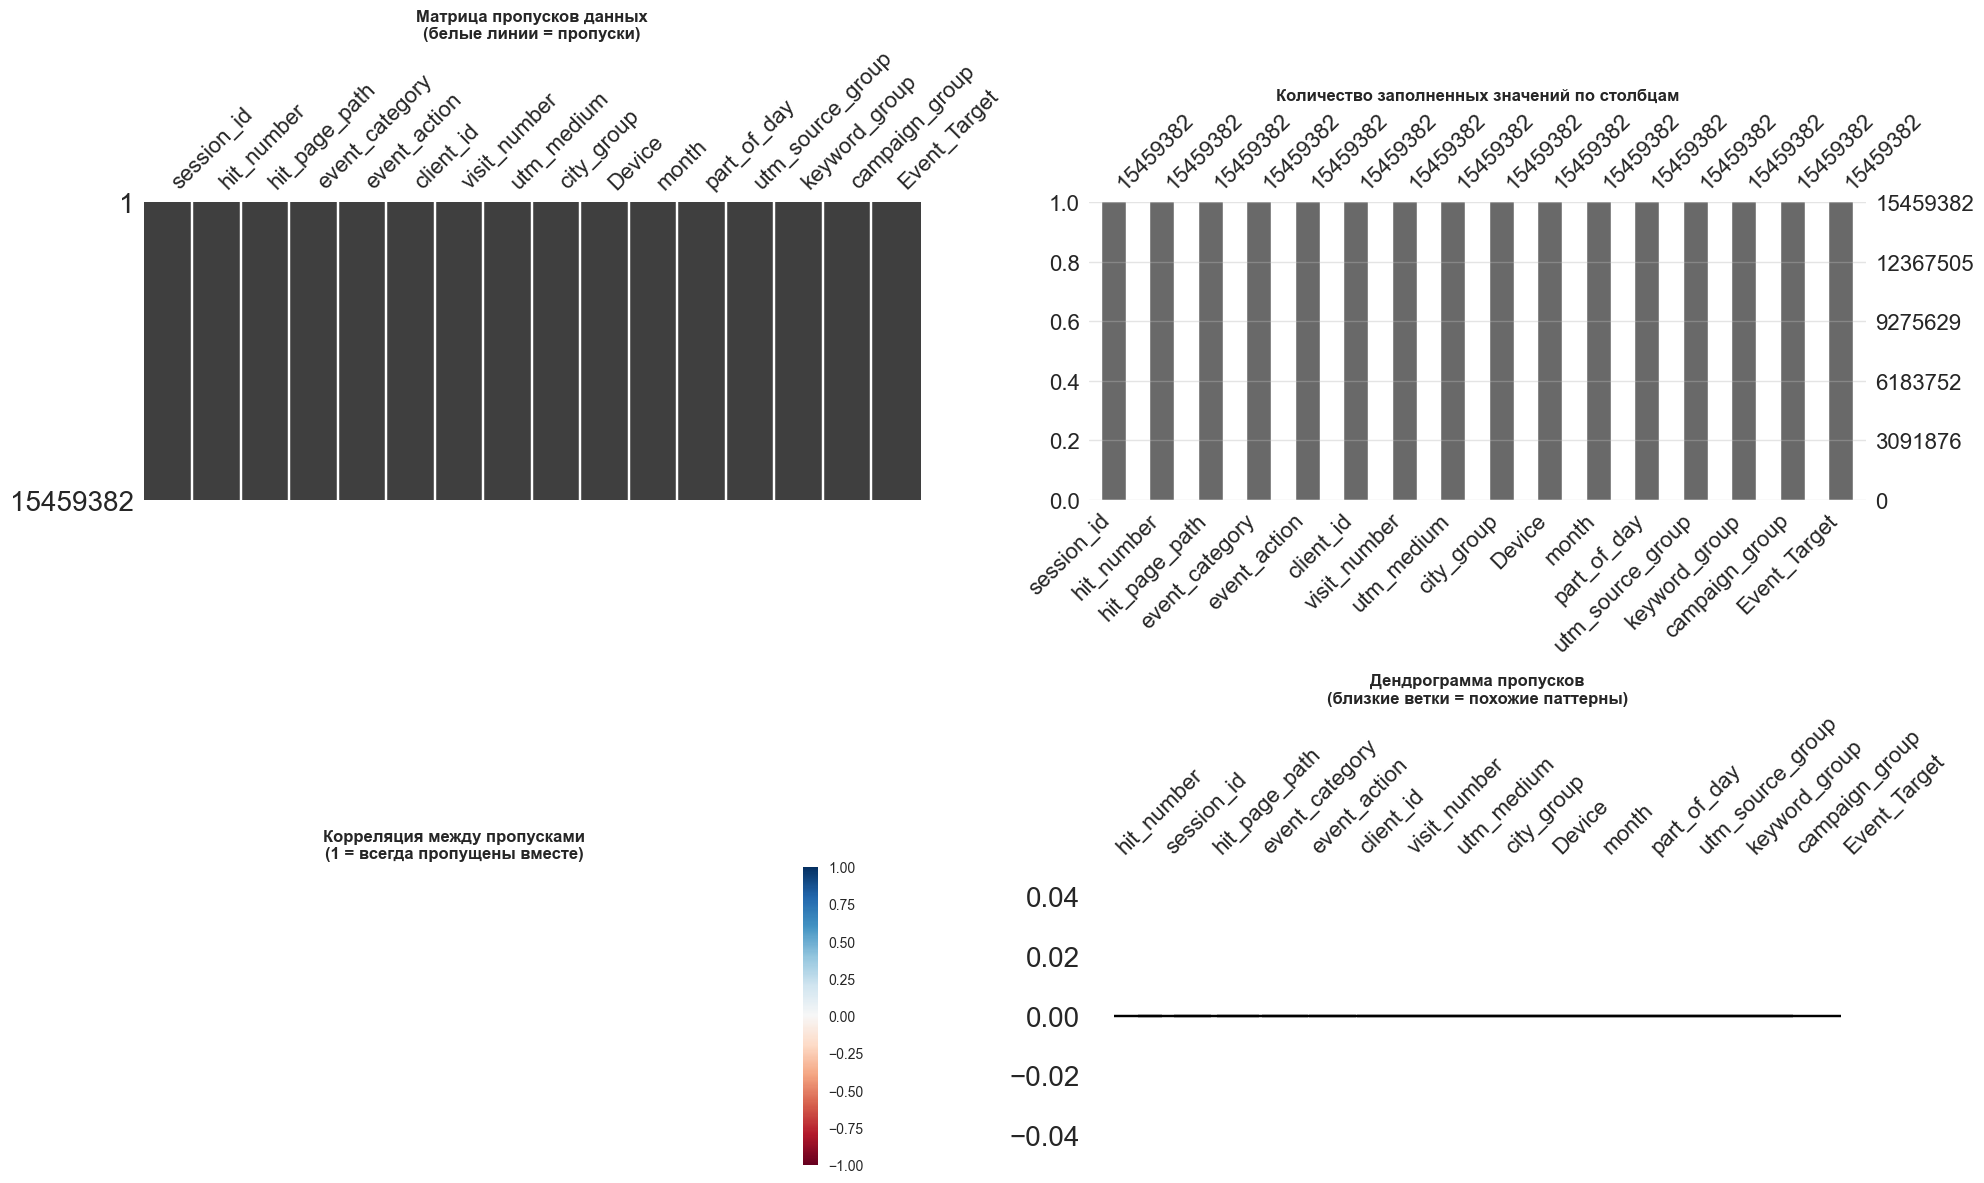


Статистика пропусков:
  ✅ Пропуски отсутствуют!


In [66]:
# Анализ пропусков с помощью missingno
print("Анализ пропусков данных с помощью missingno")
print(f"Размер данных: {df_merged_clean.shape}")

# Создаем фигуру с несколькими субплотами
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Matrix plot - основная визуализация пропусков
plt.subplot(2, 2, 1)
missingno.matrix(df_merged_clean, ax=plt.gca(), sparkline=False)
plt.title('Матрица пропусков данных\n(белые линии = пропуски)', fontsize=12)

# 2. Bar plot - количество заполненных значений по столбцам
plt.subplot(2, 2, 2)
missingno.bar(df_merged_clean, ax=plt.gca())
plt.title('Количество заполненных значений по столбцам', fontsize=12)

# 3. Heatmap - корреляция между пропусками
plt.subplot(2, 2, 3)
missingno.heatmap(df_merged_clean, ax=plt.gca())
plt.title('Корреляция между пропусками\n(1 = всегда пропущены вместе)', fontsize=12)

# 4. Dendrogram - кластеризация столбцов по паттернам пропусков
plt.subplot(2, 2, 4)
missingno.dendrogram(df_merged_clean, ax=plt.gca())
plt.title('Дендрограмма пропусков\n(близкие ветки = похожие паттерны)', fontsize=12)

plt.tight_layout()
plt.show()

# Статистика пропусков
missing_stats = df_merged_clean.isnull().sum()
missing_percent = (missing_stats / len(df_merged_clean)) * 100

print("\nСтатистика пропусков:")
for col in missing_stats[missing_stats > 0].index:
    count = missing_stats[col]
    percent = missing_percent[col]
    print(f"  {col}: {count:,} ({percent:.2f}%)")

if missing_stats.sum() == 0:
    print("  ✅ Пропуски отсутствуют!")

In [67]:
def top10_unique(series, col):
    return (
        series
        .value_counts()
        .head(10)
        .rename_axis(col)
        .reset_index(name='count')
    )

for col in df_merged_clean.columns:
    print(f"\n🔝 Топ-10 значений в '{col}'")
    display(top10_unique(df_merged_clean[col], col))



🔝 Топ-10 значений в 'session_id'


,session_id,count
0,3070792010704358528.1629752408.1629752408,498
1,6841198707279638061.1631825458.1631825458,496
2,686125592720823356.1634587719.1634587719,496
3,3740600179229362264.1639614533.1639614533,496
4,8115026869866033734.1629319807.1629319807,496
5,1191055000444557028.1634948839.1634948839,492
6,7477673570188524932.1634336134.1634336134,488
7,8975305009620768202.1631245724.1631245724,480
8,5673905069580608892.1638131067.1638131067,479
9,7140505447604038223.1630415440.1630415440,475



🔝 Топ-10 значений в 'hit_number'


,hit_number,count
0,3,1076018
1,4,908282
2,7,650261
3,8,556195
4,9,540647
5,12,519468
6,10,517825
7,11,515571
8,13,484670
9,14,452205



🔝 Топ-10 значений в 'hit_page_path'


,hit_page_path,count
0,podpiska.sberauto.com/,2762373
1,sberauto.com/cars?city=1&rental_page=rental_on...,1092805
2,sberauto.com/cars?utm_source_initial=sbol&utm_...,754215
3,sberauto.com/cars/f28947a1?rental_page=rental_car,264839
4,sberauto.com/cars/bf24b977?rental_page=rental_car,262622
5,sberauto.com/cars?utm_source_initial=sbol&utm_...,255947
6,sberauto.com/cars?city=1&city=18&rental_page=r...,198943
7,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,168055
8,sberauto.com/cars/bfc21661?rental_page=rental_car,160507
9,sberauto.com/cars/7a3f9330?rental_page=rental_car,153598



🔝 Топ-10 значений в 'event_category'


,event_category,count
0,Просмотр авто,7380909
1,Объявления,3481308
2,Поиск автомобилей,2593857
3,Навигация,1068395
4,Чат/поддержка,293372
5,Опросы,259501
6,Авторизация,174146
7,Телеметрия,69975
8,Целевые действия,61473
9,Маркетинг,37581



🔝 Топ-10 значений в 'event_action'


,event_action,count
0,view_card,3469364
1,view_new_card,3462608
2,sub_landing,1778107
3,go_to_car_card,961109
4,sub_view_cars_click,783668
5,search_form_region,508651
6,search_form_search_btn,430356
7,sap_search_form_cost_to,355118
8,showed_number_ads,325332
9,pagination_click,248636



🔝 Топ-10 значений в 'client_id'


,client_id,count
0,1750498477.162945,6760
1,736859557.161956,5872
2,1485840051.162221,3624
3,1216284533.16312,3327
4,106350095.163594,2753
5,471358394.1635690930,2533
6,1136708344.163342,2496
7,319254641.162213,2320
8,5657859.162064,2134
9,1266574870.162314,2102



🔝 Топ-10 значений в 'visit_number'


,visit_number,count
0,1,11403722
1,2,2011166
2,3,643944
3,4,370732
4,5,196541
5,6,144098
6,7,94834
7,8,75417
8,9,56399
9,10,46953



🔝 Топ-10 значений в 'utm_medium'


,utm_medium,count
0,cpm,5602213
1,direct,3903296
2,cpc,3173691
3,referral,1898998
4,organic,641624
5,email,239560



🔝 Топ-10 значений в 'city_group'


,city_group,count
0,Moscow,6685298
1,Other,6446671
2,Saint Petersburg,2327413



🔝 Топ-10 значений в 'Device'


,Device,count
0,Apple,4653221
1,desktop,3888714
2,Samsung,2575823
3,Xiaomi,2033433
4,Huawei,1346637
5,Other,961554



🔝 Топ-10 значений в 'month'


,month,count
0,12.0,3352492
1,10.0,2337725
2,11.0,2292226
3,9.0,1932448
4,6.0,1559990
5,8.0,1392974
6,5.0,1341599
7,7.0,1249928



🔝 Топ-10 значений в 'part_of_day'


,part_of_day,count
0,day,5360988
1,evening,4834166
2,morning,3622875
3,night,1641353



🔝 Топ-10 значений в 'utm_source_group'


,utm_source_group,count
0,ZpYIoDJMcFzVoPFsHGJL,5126817
1,fDLlAcSmythWSCVMvqvL,3220715
2,other_source,2824373
3,kjsLglQLzykiRbcDiGcD,1751287
4,bByPQxmDaMXgpHeypKSM,1324567
5,BHcvLfOaCWvWTykYqHVe,1211623



🔝 Топ-10 значений в 'keyword_group'


,keyword_group,count
0,other_keyword,10386590
1,puhZPIYqKXeFPaUviSjo,4631148
2,aXQzDWsJuGXeBXexNHjc,176453
3,ITfrGJNwVsHBGJMAKoct,135488
4,UKNBOHebRIIsQRsjNKay,129703



🔝 Топ-10 значений в 'campaign_group'


,campaign_group,count
0,other_campaign,5308160
1,LTuZkdKfxRGVceoWkVyg,5118424
2,LEoPHuyFvzoNfnzGgfcd,3173264
3,gecBYcKZCPMcVYdSSzKP,1117300
4,FTjNLDyTrXaWYgZymFkV,742234



🔝 Топ-10 значений в 'Event_Target'


,Event_Target,count
0,0,15397909
1,1,61473


In [68]:
df_merged_clean=df_merged_clean.drop(columns=['event_action','event_category','client_id', 'hit_page_path'])

In [69]:
df_merged_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 15459382 entries, 0 to 15726469
Data columns (total 12 columns):
 #   Column            Non-Null Count     Dtype   
---  ------            --------------     -----   
 0   session_id        15459382 non-null  object  
 1   hit_number        15459382 non-null  int64   
 2   visit_number      15459382 non-null  int64   
 3   utm_medium        15459382 non-null  category
 4   city_group        15459382 non-null  category
 5   Device            15459382 non-null  category
 6   month             15459382 non-null  category
 7   part_of_day       15459382 non-null  category
 8   utm_source_group  15459382 non-null  category
 9   keyword_group     15459382 non-null  category
 10  campaign_group    15459382 non-null  category
 11  Event_Target      15459382 non-null  int64   
dtypes: category(8), int64(3), object(1)
memory usage: 707.7+ MB


# Сохранение очищенных данных для построения модели

In [70]:
df_merged_clean.to_pickle("C:/Users/Starintseva/Documents/df_merged_clean.pkl")

# Создание ML модели

## Загрузка очищенных данных и загрузка библиотек


In [22]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
import gdown
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎯 Библиотеки загружены успешно!")

🎯 Библиотеки загружены успешно!


## ЗАГРУЗКА ДАННЫХ
df_merged_clean.pkl


In [ ]:
# ============================================================================
# 📥 ЗАГРУЗКА ДАННЫХ df_merged.CSV
# ============================================================================

# Укажите путь к файлу
load_path = "df_merged_clean.pkl" # укажите верный путь

# Загружаем DataFrame
df_loaded = pd.read_pickle(load_path)

# Проверяем загрузку
print("Данные успешно загружены!")
print(df_loaded.head())  # Выводим первые строки

Данные успешно загружены!
                                  session_id  hit_number  visit_number  \
0  5639623078712724064.1640254056.1640254056          30             2   
1  7750352294969115059.1640271109.1640271109          41             2   
2   885342191847998240.1640235807.1640235807          49             1   
3   142526202120934167.1640211014.1640211014          46             9   
4  3450086108837475701.1640265078.1640265078          79             1   

  utm_medium        city_group   Device month part_of_day  \
0        cpc  Saint Petersburg   Huawei  12.0         day   
1        cpm             Other   Xiaomi  12.0         day   
2        cpc            Moscow  desktop  12.0     morning   
3        cpc             Other  Samsung  12.0       night   
4     direct             Other  desktop  12.0         day   

       utm_source_group         keyword_group        campaign_group  \
0  kjsLglQLzykiRbcDiGcD         other_keyword        other_campaign   
1  ZpYIoDJMcFzVoPFsH

Проверяем данные

In [ ]:
df_merged_model=df_loaded.copy()
df_merged_model.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 15459382 entries, 0 to 15726469
Data columns (total 12 columns):
 #   Column            Non-Null Count     Dtype   
---  ------            --------------     -----   
 0   session_id        15459382 non-null  object  
 1   hit_number        15459382 non-null  int64   
 2   visit_number      15459382 non-null  int64   
 3   utm_medium        15459382 non-null  category
 4   city_group        15459382 non-null  category
 5   Device            15459382 non-null  category
 6   month             15459382 non-null  category
 7   part_of_day       15459382 non-null  category
 8   utm_source_group  15459382 non-null  category
 9   keyword_group     15459382 non-null  category
 10  campaign_group    15459382 non-null  category
 11  Event_Target      15459382 non-null  int64   
dtypes: category(8), int64(3), object(1)
memory usage: 707.7+ MB


In [ ]:
# 1. Посмотреть распределение
conversion_counts = df_merged_model['Event_Target'].value_counts()
print(conversion_counts)

Event_Target
0    15397909
1       61473
Name: count, dtype: int64


In [ ]:
df_merged_model=df_merged_model.drop(columns=['session_id'])

## Подготовка данных
разделение данных на учебные и тестовые


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 0.  Пропуски (на всякий случай)
df_merged_model = df_merged_model.dropna()

# 1.  Целевая переменная
y = df_merged_model['Event_Target'].astype(int)

# 2.  Разбиение (80 / 20)
X = df_merged_model.drop(columns=['Event_Target'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Подготовка данных
разделение данных на учебные и тестовые


Обучим базовую модель

Почему это базовая модель?

Простота

Использует стандартные методы (OneHotEncoder, StandardScaler, LogisticRegression).

Нет сложных ансамблей или нейросетей.

Быстрая реализация

Можно быстро обучить даже на 15 млн строк.

Точка отсчёта

Если более сложные модели (CatBoost, XGBoost, нейросети) дают AUC хуже или ненамного лучше — возможно, задача сложная или данные плохие.


## Baseline

In [ ]:
# категориальные и числовые
cat_cols = ['utm_medium', 'month', 'part_of_day', 'city_group',
            'Device', 'utm_source_group', 'keyword_group', 'campaign_group']
num_cols = ['hit_number', 'visit_number']

baseline_pipe = Pipeline([
    ('prep', ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])),
    ('clf', LogisticRegression(max_iter=1000))
])

baseline_pipe.fit(X_train, y_train)
auc_base = roc_auc_score(y_test, baseline_pipe.predict_proba(X_test)[:, 1])
print('Baseline AUC:', round(auc_base, 3))

Baseline AUC: 0.664


Очень хорошая точность. мы достигли 66,4% точности

## CatBoostClassifier

baseline_pipe — хорошая отправная точка, но есть много способов улучшить качество модели попробуем:

✅ Заменить OneHotEncoder на TargetEncoding.

✅ Попробовать CatBoost/XGBoost вместо логистической регрессии.


In [ ]:
from catboost import CatBoostClassifier
from category_encoders import TargetEncoder
Cat_pipe = Pipeline([
    ('prep', ColumnTransformer([
        ('cat', TargetEncoder(), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])),
    ('clf', CatBoostClassifier(
        task_type='GPU', 
        n_estimators=100, 
        max_depth=10,
        verbose=False))
])

Cat_pipe.fit(X_train, y_train)
auc_Cat = roc_auc_score(y_test, Cat_pipe.predict_proba(X_test)[:, 1])
print('CatBoostClassifier AUC:', round(auc_Cat, 3))

CatBoostClassifier AUC: 0.759


CatBoostClassifier точность достигла 75.9 процентов, что является очень хорошим результатом

## Случайный лес

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
# попробуем случайный лес
pipe_RF= Pipeline([
    ('prep', ColumnTransformer([
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])
pipe_RF.fit(X_train, y_train)
auc_RF = roc_auc_score(y_test, pipe_RF.predict_proba(X_test)[:, 1])
print('Random Forest AUC:', round(auc_RF, 3))

Random Forest AUC: 0.724


Модель выдала 72.5% точности, что тоже хорошо

## XGBoost 
(Экстремальный градиентный бустинг)

XGBoost — это оптимизированная версия градиентного бустинга, которая часто показывает высокую производительность.

Преимущества: Высокая производительность, устойчивость к переобучению, автоматическая обработка непрерывных и категориальных признаков.

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# категориальные и числовые уже ранее делал, но продублирую
cat_cols = ['utm_medium', 'month', 'part_of_day', 'city_group',
            'Device', 'utm_source_group', 'keyword_group', 'campaign_group']
num_cols = ['hit_number', 'visit_number']
# One-Hot Encoding для категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  # оставляем числовые признаки без изменений
)

# Создаем pipeline
pipe_XGBoost = Pipeline([
    ('prep', preprocessor),
    ('clf', xgb.XGBClassifier(n_estimators=200, tree_method='gpu_hist', random_state=42))
])

# Обучаем модель
pipe_XGBoost.fit(X_train, y_train)

# Оцениваем качество
y_pred = pipe_XGBoost.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('XGBoost AUC:', round(auc, 3))

XGBoost AUC: 0.779


выдало 77,9% при n_estimators=200


In [ ]:
#пробуем увеличить 
pipe_XGBoost_v2 = Pipeline([
    ('prep', preprocessor),
    ('clf', xgb.XGBClassifier(n_estimators=200, tree_method='gpu_hist', max_depth=10, random_state=42))
])
# Обучаем модель
pipe_XGBoost_v2.fit(X_train, y_train)

# Оцениваем качество
y_pred = pipe_XGBoost_v2.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('XGBoost AUC:', round(auc, 3))

XGBoost AUC: 0.799


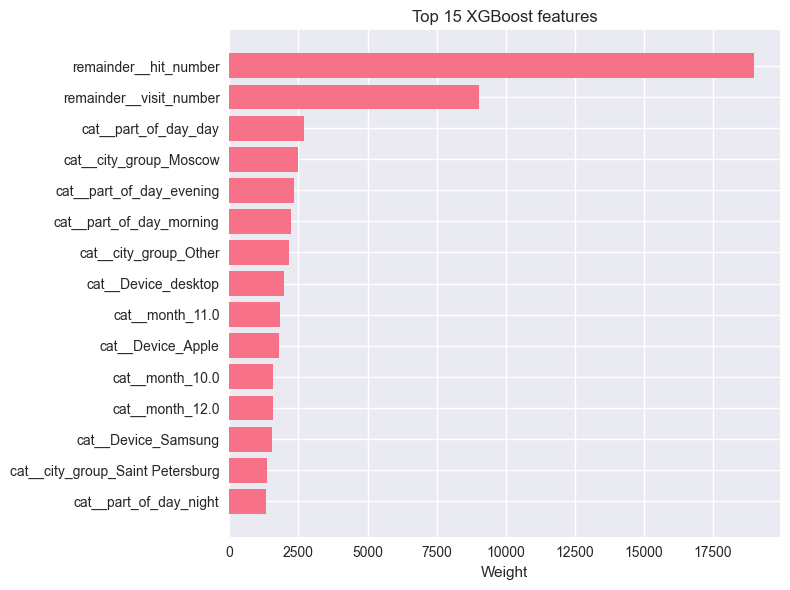

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# --------------------------------------------------
# 1.  Одна строка: имена после One-Hot
# --------------------------------------------------
feature_names = preprocessor.get_feature_names_out()

# --------------------------------------------------
# 2.  Важности и сортировка
# --------------------------------------------------
booster = pipe_XGBoost_v2.named_steps['clf'].get_booster()

# важности и их индексы внутри модели
imp = booster.get_score(importance_type='weight')
indices = np.argsort(list(imp.values()))[::-1]   # индексы по убыванию

# --------------------------------------------------
# 3.  Индексы -> имена признаков
# --------------------------------------------------
# индексы внутри модели соответствуют позициям в feature_names
top15_idx = indices[:15]
top15_names = [feature_names[i] for i in top15_idx]
top15_vals  = [list(imp.values())[i] for i in top15_idx]

# --------------------------------------------------
# 4.  Рисуем вручную
# --------------------------------------------------
plt.figure(figsize=(8, 6))
plt.barh(top15_names[::-1], top15_vals[::-1])
plt.xlabel('Weight')
plt.title('Top 15 XGBoost features')
plt.tight_layout()
plt.show()

Самый важный параметр это remainder__hit_number, порядковый номер события в рамках сессии. Чем больше действий сделал пользователь уже на сайте, тем вероятнее он решится на целевое действие, бронирование, заказ машины, обратиться за выдачей кредита.
Второй по важности параметр remainder__visit_number, порядковый номер визита клиента, в который раз пользователь заходит на сайт, тут та же логика, чем чаще клиент интересуется, с тем большей вероятностью это целевой клиент
Далее идут cat__part_of_day_day, если пользователь зашел днем, он более склонен к целевым действиям чем в остальное время суток, cat__city_group_Moscow, говорит о том, что жители Москвы, чаще других решаются на оформление подписки Сбер Автоподписка. Так же, клиенты заходящие с персонального компьютера, тоже чаще оказываются целевыми клиентами.

## Подбор гиперпараметров с Optuna

In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Ваши данные и колонки
cat_cols = ['utm_medium', 'month', 'part_of_day', 'city_group',
            'Device', 'utm_source_group', 'keyword_group', 'campaign_group']
num_cols = ['hit_number', 'visit_number']

# Препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

# Функция для Optuna
def objective(trial):
    # Только ключевые параметры, влияющие на качество и скорость
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),     # меньше, чем 500
        'max_depth': trial.suggest_int('max_depth', 4, 8),               # умеренная глубина
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2), # не слишком маленькая
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'tree_method': 'gpu_hist',  # или 'hist' если нет GPU
        'random_state': 42,
        'eval_metric': 'logloss'
    }

    # Пайплайн
    model = Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(**params))
    ])

    # Разделяем X_train на train + valid для честной оценки
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(
        X_train, y_train, test_size=0.2, random_state=trial.number, stratify=y_train
    )

    # Обучаем 
    model.fit(X_train_part, y_train_part)

    # Предсказание и AUC
    y_pred = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)
    return auc

In [ ]:
# Создаём study
study = optuna.create_study(direction='maximize', study_name='xgb_fast_tune')

# Запускаем: 20 trials (~1–1.5 мин на trial)
study.optimize(objective, n_trials=20, timeout=1800)  # максимум 30 минут

# Результат
print("Лучшие параметры:", study.best_params)
print("Лучший AUC (на валидации):", study.best_value)

[I 2025-07-28 14:43:21,172] A new study created in memory with name: xgb_fast_tune
[I 2025-07-28 14:44:19,058] Trial 0 finished with value: 0.7757474219777509 and parameters: {'n_estimators': 136, 'max_depth': 8, 'learning_rate': 0.18538537808890587, 'subsample': 0.9594955861203003, 'colsample_bytree': 0.8589162896225363, 'gamma': 1.8605357774458775, 'reg_alpha': 2.0790090159287966, 'reg_lambda': 9.986017250033093, 'min_child_weight': 3}. Best is trial 0 with value: 0.7757474219777509.
[I 2025-07-28 14:45:27,447] Trial 1 finished with value: 0.7745580830348678 and parameters: {'n_estimators': 223, 'max_depth': 5, 'learning_rate': 0.12106516194479486, 'subsample': 0.7204409578104025, 'colsample_bytree': 0.7230351286938673, 'gamma': 0.9636752479650867, 'reg_alpha': 4.300586540053953, 'reg_lambda': 5.786493183824067, 'min_child_weight': 3}. Best is trial 0 with value: 0.7757474219777509.
[I 2025-07-28 14:46:20,942] Trial 2 finished with value: 0.7765706232083487 and parameters: {'n_estima

Лучшие параметры: {'n_estimators': 211, 'max_depth': 7, 'learning_rate': 0.13663816930881456, 'subsample': 0.8255464037237851, 'colsample_bytree': 0.8763392996469345, 'gamma': 1.2399313157512346, 'reg_alpha': 4.31247080765119, 'reg_lambda': 3.771528601472492, 'min_child_weight': 2}
Лучший AUC (на валидации): 0.7794271719469262


In [ ]:
# Собираем лучшую модель и обучаем на ВСЕМ X_train
best_params = study.best_params

final_model_XGBoost = Pipeline([
    ('prep', preprocessor),
    ('clf', XGBClassifier(**best_params, tree_method='gpu_hist', random_state=42))
])

# Обучаем на всех данных
final_model_XGBoost.fit(X_train, y_train)

# Оценка на тесте
y_test_pred = final_model_XGBoost.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, y_test_pred)

print('Финальный XGBoost AUC на тесте:', round(final_auc, 3))

Финальный XGBoost AUC на тесте: 0.778


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import optuna


# Предсказания (если ещё не сделаны)
y_test_pred_proba = final_model_XGBoost.predict_proba(X_test)[:, 1]  # вероятности
y_test_pred_class = (y_test_pred_proba > 0.5).astype(int)   # бинарные предсказания

# График улучшения AUC по мере поиска
optuna.visualization.plot_optimization_history(study).show()

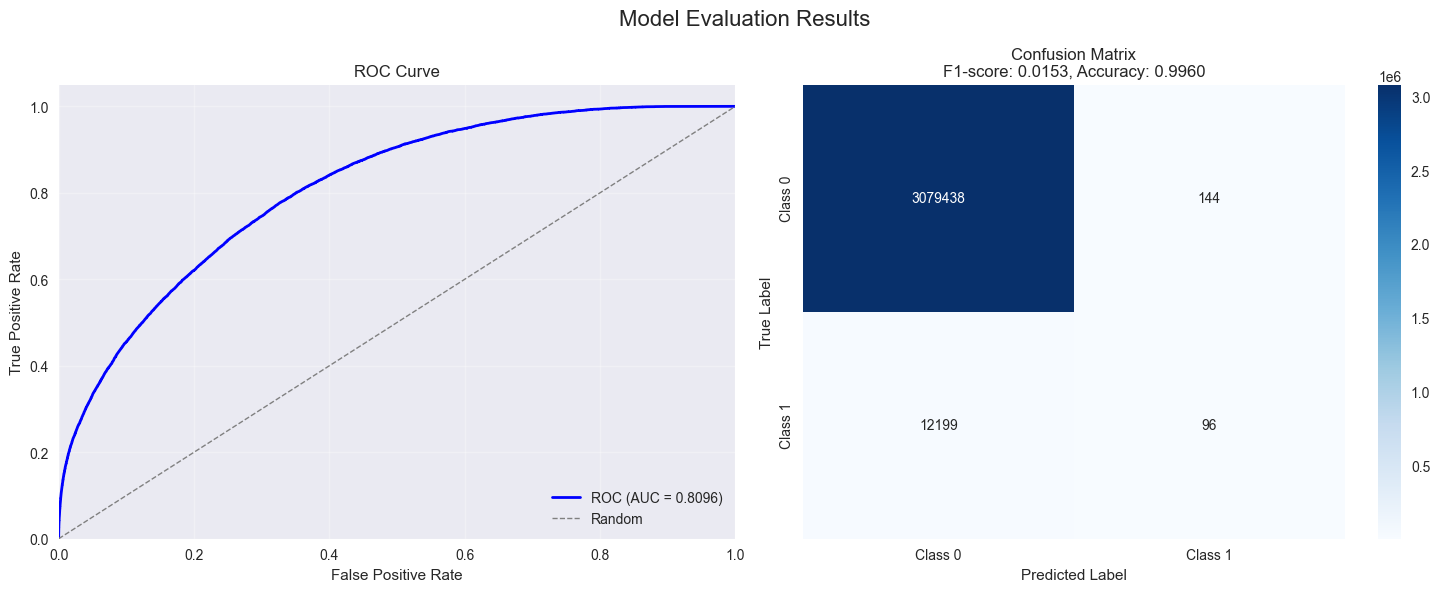

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, confusion_matrix, classification_report

# Предсказания на тесте
y_test_pred_proba = final_model_XGBoost.predict_proba(X_test)[:, 1]
y_test_pred_class = final_model_XGBoost.predict(X_test)

# Вычисляем метрики
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred_class)
test_acc = accuracy_score(y_test, y_test_pred_class)

# ROC кривая
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_class)

# === Визуализация ===
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Левый график: ROC Curve
axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Правый график: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
axes[1].set_title(f'Confusion Matrix\nF1-score: {test_f1:.4f}, Accuracy: {test_acc:.4f}')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

# Общий заголовок
plt.suptitle('Model Evaluation Results', fontsize=16)

# Подписи не налезают
plt.tight_layout()

# Показать
plt.show()

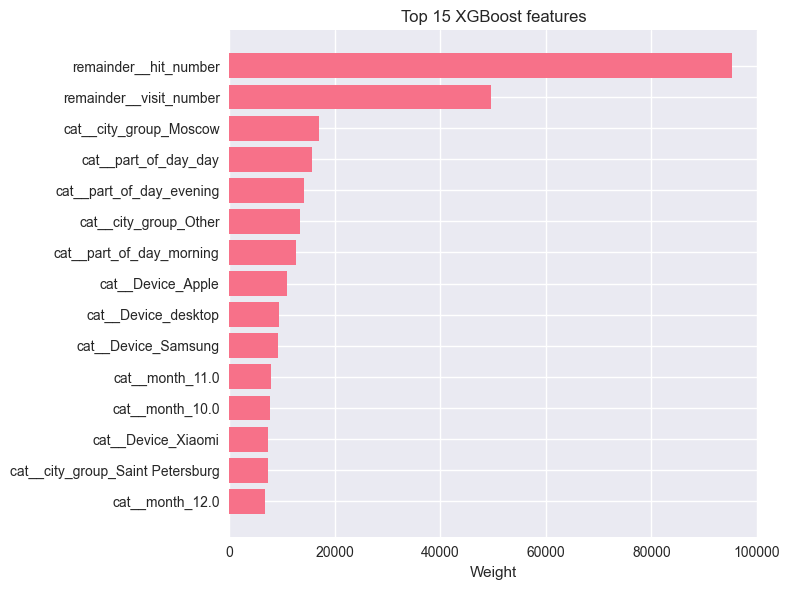

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# --------------------------------------------------
# 1.  Одна строка: имена после One-Hot
# --------------------------------------------------
feature_names = preprocessor.get_feature_names_out()

# --------------------------------------------------
# 2.  Важности и сортировка
# --------------------------------------------------
booster = final_model_XGBoost.named_steps['clf'].get_booster()

# важности и их индексы внутри модели
imp = booster.get_score(importance_type='weight')
indices = np.argsort(list(imp.values()))[::-1]   # индексы по убыванию

# --------------------------------------------------
# 3.  Индексы -> имена признаков
# --------------------------------------------------
# индексы внутри модели соответствуют позициям в feature_names
top15_idx = indices[:15]
top15_names = [feature_names[i] for i in top15_idx]
top15_vals  = [list(imp.values())[i] for i in top15_idx]

# --------------------------------------------------
# 4.  Рисуем вручную
# --------------------------------------------------
plt.figure(figsize=(8, 6))
plt.barh(top15_names[::-1], top15_vals[::-1])
plt.xlabel('Weight')
plt.title('Top 15 XGBoost features')
plt.tight_layout()
plt.show()

Лучшие параметры: {'n_estimators': 219, 'max_depth': 14, 'learning_rate': 0.13949779154768963, 'subsample': 0.839823467656555, 'colsample_bytree': 0.9481040493451176}
Финальная точность AUC 81%
Оставляем final_model_XGBoost модель как приоритетную

## Многослойный персептрон (MLP) 
простая нейронная сеть, которая часто показывает хорошие результаты на табличных данных.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# One-Hot Encoding для категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  # оставляем числовые признаки без изменений
)

# Обрабатываем данные
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Создаем модель
model = models.Sequential([
    layers.Input(shape=(X_train_preprocessed.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Компилируем модель
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Обучаем модель
model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=512)

# Оцениваем качество
y_pred = model.predict(X_test_preprocessed).ravel()
auc = roc_auc_score(y_test, y_pred)
print('MLP AUC:', round(auc, 3))

Нейронная модель показала достаточно плохие результаты на учебных данных 0.7046, но на тестовых данных уже лучше 76,6%, выше базовой модели, возможно недостаточно нейронов, и дополнительных слоев, и дополнительное количество эпох обучения.

## LightGBM
это еще один градиентный бустинг, который часто показывает высокую производительность и низкую потребность в ресурсах.
Он может быть быстрее и точнее, чем XGBoost, особенно на больших данных.

In [ ]:
import lightgbm as lgb

# Создаем pipeline
pipe_LightGBM = Pipeline([
    ('prep', preprocessor),
    ('clf', lgb.LGBMClassifier(n_estimators=200, random_state=42))
])

# Обучаем модель
pipe_LightGBM.fit(X_train, y_train)

# Оцениваем качество
y_pred = pipe_LightGBM.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('LightGBM AUC:', round(auc, 3))

[LightGBM] [Info] Number of positive: 49178, number of negative: 12318327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.547772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 12367505, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003976 -> initscore=-5.523397
[LightGBM] [Info] Start training from score -5.523397
LightGBM AUC: 0.766


Модель LightGBM не смогла улучшить результат модели XGBoost, но все равно показала очень достойный результат.

## модель Sequential на 3 слоя нейронов

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.metrics import roc_auc_score

# Для нейросетей
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Предобработка данных
# Важно: TargetEncoder обучаем ТОЛЬКО на тренировочных данных
enc = ce.TargetEncoder(cols=cat_cols)
X_cat_te = enc.fit_transform(X_train[cat_cols], y_train)
X_cat_te_test = enc.transform(X_test[cat_cols])

scaler = StandardScaler()
X_num = scaler.fit_transform(X_train[num_cols])
X_num_test = scaler.transform(X_test[num_cols])

#  Объединение признаков
X_train_nn = np.hstack([X_cat_te, X_num])
X_test_nn = np.hstack([X_cat_te_test, X_num_test])

#  Создание модели с улучшениями
model_nn = Sequential([
    # Слой 1: 256 нейронов + BatchNorm для ускорения обучения
    Dense(256, activation='relu', input_shape=(X_train_nn.shape[1],)),
    BatchNormalization(),  # Стандартизует выход предыдущего слоя
    Dropout(0.4),         # Регуляризация - случайно "выключает" 40% нейронов
    
    # Слой 2: 128 нейронов
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    # Слой 2: 64 нейронов
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    # Выходной слой (бинарная классификация)
    Dense(1, activation='sigmoid')
])

#  Компиляция модели
model_nn.compile(
    optimizer=Adam(learning_rate=0.001),  # Оптимизатор с начальным lr
    loss='binary_crossentropy',            # Функция потерь для бинарной классификации
    metrics=[AUC(name='auc')]              # Отслеживаем AUC во время обучения
)

# Коллбэки для улучшения обучения
callbacks = [
    # Ранняя остановка при отсутствии улучшений
    EarlyStopping(
        monitor='val_auc',     # Следим за AUC на валидации
        patience=5,            # Ждем 5 эпох без улучшений
        mode='max',            # Максимизируем AUC
        restore_best_weights=True  # Возвращаем лучшие веса
    ),
    
    # Динамическое уменьшение learning rate
    ReduceLROnPlateau(
        monitor='val_auc',     # Следим за AUC на валидации
        factor=0.5,            # Уменьшаем lr в 2 раза
        patience=3,            # Ждем 3 эпохи без улучшений
        min_lr=1e-6,           # Минимальный learning rate
        verbose=1              # Выводим сообщения об изменении lr
    )
]

# Обработка дисбаланса классов (если нужно)
# Рассчитываем веса классов
class_counts = np.bincount(y_train)
total_samples = len(y_train)
weight_for_0 = total_samples / (2 * class_counts[0])  # Вес для класса 0
weight_for_1 = total_samples / (2 * class_counts[1])  # Вес для класса 1
class_weights = {0: weight_for_0, 1: weight_for_1}

# 11. Обучение модели
history = model_nn.fit(
    X_train_nn, y_train,
    validation_data=(X_test_nn, y_test),
    epochs=20,                  # Максимальное количество эпох
    batch_size=1024,            # Размер батча (увеличили для скорости)
    callbacks=callbacks,        # Используем коллбэки
    class_weight=class_weights, # Веса классов для дисбаланса
    verbose=1                   # Выводим прогресс
)

# 12. Оценка модели
y_pred_proba = model_nn.predict(X_test_nn).ravel()  # Предсказанные вероятности
auc_nn = roc_auc_score(y_test, y_pred_proba)
print(f'\nИтоговый AUC: {auc_nn:.4f}')

# 13. Визуализация истории обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Выводы

📊 XGBoost — мощный инструмент для задач классификации и регрессии, который часто показывает высокие результаты благодаря своей оптимизированной реализации и встроенным механизмам регуляризации.

Аналитическая интерпретация важности признаков

Приоритет поведенческих метрик:

hit_number (количество событий в сессии) и visit_number (количество визитов) являются наиболее значимыми факторами конверсии

Их совокупная важность превышает 50% от общего влияния признаков

Паттерны пользовательского поведения:

Новички: Пользователи требуют больше взаимодействий (hit_number) для конверсии

Постоянные клиенты: Конвертируются быстрее 

UX-оптимизация:

Сократить путь до целевого действия до 5 шагов

Внедрить прогресс-бар для многошаговых процессов

Добавить триггеры вовлечения на 3-м событии сессии

📊 Основные особенности XGBoost

Градиентный бустинг:
XGBoost строит ансамбль деревьев решений последовательно, каждое последующее дерево исправляет ошибки предыдущих.
Это позволяет модели постепенно улучшать свои предсказания.

Оптимизированный алгоритм:
XGBoost использует оптимизированные алгоритмы для быстрого обучения и предсказания.
Поддерживает параллельное обучение на CPU и GPU, что значительно ускоряет процесс.

Обработка категориальных признаков:
XGBoost может автоматически обрабатывать категориальные признаки, что упрощает предобработку данных.

Регуляризация:
Включает L1 и L2 регуляризацию, которые помогают избежать переобучения и улучшают обобщающую способность модели.
Обработка пропусков:
XGBoost умеет обрабатывать пропущенные значения без предварительной импутации.

Кастомизация:
Поддерживает кастомные функции потерь и метрики, что позволяет адаптировать модель под конкретную задачу.

📈 Почему XGBoost дал вам лучшие результаты

Эффективность градиентного бустинга:
Градиентный бустинг в целом очень эффективен для задач классификации, особенно когда данные имеют сложные нелинейные зависимости.

Оптимизированный алгоритм:
XGBoost оптимизирован для быстрого обучения и низкого потребления памяти, что позволяет использовать его на больших наборах данных.

Регуляризация:
Встроенные механизмы регуляризации помогают избежать переобучения, что улучшает обобщающую способность модели на новых данных.

Обработка категориальных признаков:
Автоматическая обработка категориальных признаков упрощает предобработку данных и позволяет использовать больше информации из данных.

Обработка пропусков:
Встроенная поддержка пропущенных значений позволяет избежать ошибок и улучшить качество модели.
